In [1]:
# %pip install --upgrade pandas ray

In [2]:
import pandas as pd
import numpy as np
import os
import ray

2024-07-03 14:08:23,652	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:
# %pip install pandas --upgrade

import sys; sys.path.append("..")
import warnings; warnings.filterwarnings("ignore")
# from dotenv import load_dotenv; load_dotenv()
%load_ext autoreload
%autoreload 2

In [4]:
# Initialize Ray
if ray.is_initialized():
    ray.shutdown()
ray.init()

2024-07-03 14:08:27,750	INFO worker.py:1771 -- Started a local Ray instance.


Python version:,3.10.13
Ray version:,2.31.0


In [5]:
ray.cluster_resources()

{'node:172.19.2.2': 1.0,
 'accelerator_type:P100': 1.0,
 'GPU': 1.0,
 'memory': 18361452135.0,
 'object_store_memory': 9180726067.0,
 'CPU': 4.0,
 'node:__internal_head__': 1.0}

## Data

### 🔢Data ingestion

In [6]:
dataset= pd.read_csv('/kaggle/input/nlp-classification/nlp_dataset/dataset.csv')
dataset.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


In [7]:
dataset.tag.value_counts()

tag
natural-language-processing    310
computer-vision                285
other                          106
mlops                           63
Name: count, dtype: int64

### ✂ Data splitting

### Splitting
#### Next, we need to split our training dataset into train and val data splits.

1. Use the train split to train the model.
>  Here the model will have access to both inputs (features) and outputs (labels) to optimize its internal weights.

2. After each iteration (epoch) through the training split, we will use the val split to determine the model's performance.
> Here the model will not use the labels to optimize its weights but instead, we will use the validation performance to optimize training hyperparameters such as the learning rate, etc.

3. Finally, we will use a separate holdout test dataset to determine the model's performance after training.
> This is our best measure of how the model may behave on new, unseen data that is from a similar distribution to our training dataset.

In [8]:
from sklearn.model_selection import train_test_split

> For our multi-class task (where each project has exactly one tag), we want to ensure that the data splits have similar class distributions. We can achieve this by specifying how to `stratify` the split by using the stratify keyword argument with sklearn's `train_test_split()` function.

In [9]:
# Split dataset
test_size = 0.2
train_df, val_df = train_test_split(dataset, stratify=dataset.tag, test_size=test_size, random_state=1234)

> How can we validate that our data splits have similar class distributions? We can view the frequency of each class in each split:

In [10]:
# Train value counts
train_df.tag.value_counts()

tag
natural-language-processing    248
computer-vision                228
other                           85
mlops                           50
Name: count, dtype: int64

> Before we view our validation split's class counts, recall that our validation split is only `test_size` of the entire dataset. So we need to adjust the value counts so that we can compare it to the training split's class counts.

In [11]:
# Validation (adjusted) value counts
val_df.tag.value_counts() * int((1-test_size) / test_size)

tag
natural-language-processing    248
computer-vision                228
other                           84
mlops                           52
Name: count, dtype: int64

> These adjusted counts looks very similar to our train split's counts. Now we're ready to explore our dataset!

### 🔍Exploratory Data Analysis (EDA)
> Exploratory data analysis to understand the signals and nuances of our dataset. It's a cyclical process that can be done at various points of our development process (before/after labeling, preprocessing, etc.) depending on how well the problem is defined. For example, if we're unsure how to label or preprocess our data, we can use EDA to figure it out.

#### We're going to start our project with EDA, a vital (and fun) process that's often misconstrued. Here's how to think about EDA:

* not just to visualize a prescribed set of plots (correlation matrix, etc.).
* goal is to convince yourself that the data you have is sufficient for the task.
* use EDA to answer important questions and to make it easier to extract insight
* not a one time process; as your data grows, you want to revisit EDA to catch distribution shifts, anomalies, etc.


**Let's answer a few key questions using EDA.**



In [12]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import warnings; warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS

### Tag distribution
> How many data points do we have per tag? We'll use the `Counter` class to get counts for all the different tags.

In [13]:
# Most common tags
all_tags = Counter(dataset.tag)
all_tags.most_common()

[('natural-language-processing', 310),
 ('computer-vision', 285),
 ('other', 106),
 ('mlops', 63)]

We can then separate the tags and from their respective counts and plot them using `Plotly.`

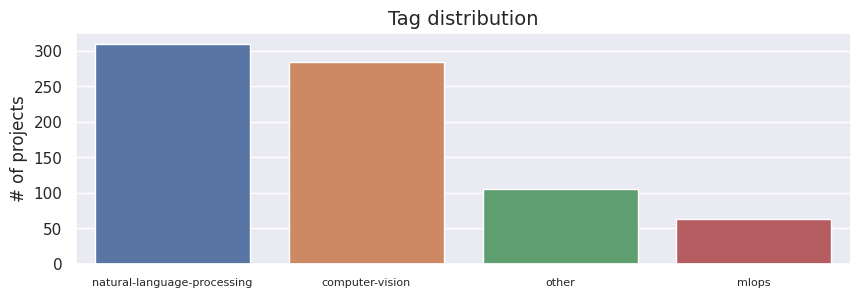

In [14]:
# Plot tag frequencies
tags, tag_counts = zip(*all_tags.most_common())
plt.figure(figsize=(10, 3))
ax = sns.barplot(x=list(tags), y=list(tag_counts))
ax.set_xticklabels(tags, rotation=0, fontsize=8)
plt.title("Tag distribution", fontsize=14)
plt.ylabel("# of projects", fontsize=12)
plt.show()

> We do have some data imbalance but it's not too bad. If we did want to account for this, there are many strategies, including `over-sampling` less frequent classes and `under-sampling` popular classes, `class weights in the loss function`, etc.

### Wordcloud
> Is there enough signal in the title and description that's unique to each tag? This is important to know because we want to verify our initial hypothesis that the project's title and description are high quality features for predicting the tag. And to visualize this, we're going to use a `wordcloud`. We also use a `jupyter widget`, which you can view in the `notebook`, to interactively select a tag and see the wordcloud for that tag.

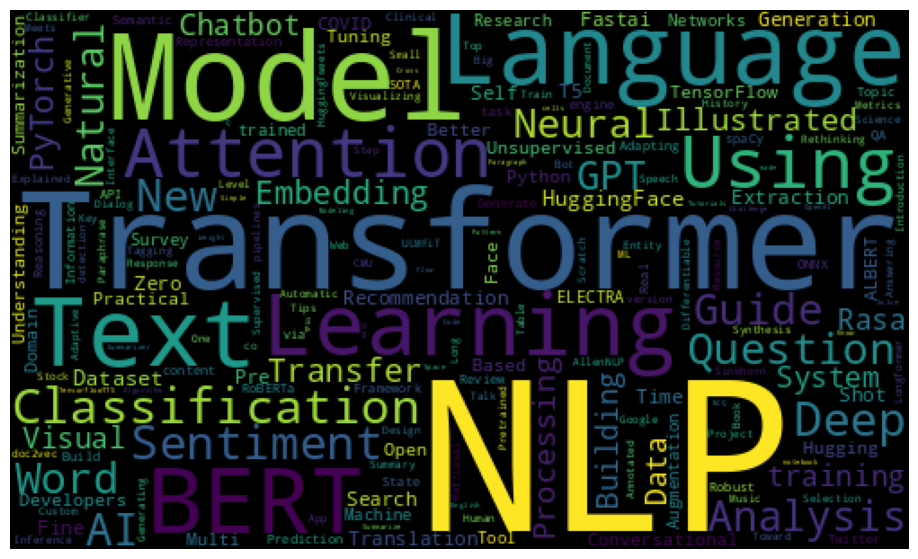

In [15]:
# Most frequent tokens for each tag
tag="natural-language-processing"
plt.figure(figsize=(15, 7))
subset = dataset[dataset.tag==tag]
text = subset.title.values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", collocations=False,
    width=500, height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

> Looks like the `title` text feature has some good signal for the respective classes and matches our intuition. We can repeat this for the `description` text feature as well and see similar quality signals. This information will become useful when we decide how to use our features for modeling.

### ✨ Data Preprocessing

Preprocessing the data via feature engineering, filtering and cleaning. Certain preprocessing steps are global (don't depend on our dataset, ex. lower casing text, removing stop words, etc.) and others are local (constructs are learned only from the training split, ex. vocabulary, standardization, etc.). For the local, dataset-dependent preprocessing steps, we want to ensure that we split the data first before preprocessing to avoid data leaks.

### Missing values
> First, we'll have to identify the rows with missing values and once we do, there are several approaches to dealing with them.

> omit samples with missing values (if only a small subset are missing it)

In [16]:
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

### Feature engineering
> We can combine existing input features to create new meaningful signal for helping the model learn. However, there's usually no simple way to know if certain feature combinations will help or not without empirically experimenting with the different combinations. Here, we could use a project's title and description separately as features but we'll combine them to create one input feature.

In [17]:
# Input
dataset["text"] = dataset.title + " " + dataset.description

### Cleaning
> Since we're dealing with text data, we can apply some common text preprocessing operations. Here, we'll be using Python's built-in regular expressions library `re` and the Natural Language Toolkit `nltk`.

In [18]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
def clean_text(text, stopwords=STOPWORDS):
    """Clean raw text string."""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links

    return text

In [20]:
# Apply to dataframe
original_df = dataset.copy()
dataset.text = dataset.text.apply(clean_text)
print (f"{original_df.text.values[0]}\n{dataset.text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


> We'll wrap up our cleaning operation by removing columns `(pandas.DataFrame.drop)` and rows with null tag values `(pandas.DataFrame.dropna)`.

### Clean Dataframe

In [21]:
# DataFrame cleanup
dataset = dataset.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # drop cols
dataset = dataset.dropna(subset=["tag"])  # drop nulls
dataset = dataset[["text", "tag"]]  # rearrange cols
dataset.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,computer-vision
1,show infer tell contextual inference creative ...,computer-vision
2,awesome graph classification collection import...,other
3,awesome monte carlo tree search curated list m...,other
4,attentionwalk pytorch implementation watch ste...,other


### Label Encoding
> We need to encode our data into numerical values so that our models can process them. We'll start by encoding our text labels into unique indices.

In [22]:
# Label to index
tags = train_df.tag.unique().tolist()
num_classes = len(tags)
class_to_index = {tag: i for i, tag in enumerate(tags)}
class_to_index

{'mlops': 0,
 'natural-language-processing': 1,
 'computer-vision': 2,
 'other': 3}

> Next, we can use the `pandas.Series.map` function to map our `class_to_index` dictionary on our tag column to encode our labels

In [23]:
# Encode labels
dataset["tag"] = dataset["tag"].map(class_to_index)
dataset.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,2
1,show infer tell contextual inference creative ...,2
2,awesome graph classification collection import...,3
3,awesome monte carlo tree search curated list m...,3
4,attentionwalk pytorch implementation watch ste...,3


> We'll also want to be able to decode our predictions back into text labels. We can do this by creating an `index_to_class` dictionary and using that to convert encoded labels back into text labels.

In [24]:
def decode(indices, index_to_class):
    return [index_to_class[index] for index in indices]

In [25]:
index_to_class = {v:k for k, v in class_to_index.items()}
decode(dataset.head()["tag"].values, index_to_class=index_to_class)

['computer-vision', 'computer-vision', 'other', 'other', 'other']

> Next we'll encode our text as well. Instead of using a random dictionary, we'll use a `tokenizer` that was used for a pretrained `LLM (scibert)` to tokenize our text. We'll be fine-tuning this exact model later when we train our model.

### Tokenizer
> Next we'll encode our text as well. Instead of using a random dictionary, we'll use a `tokenizer` that was used for a pretrained LLM `(scibert)` to tokenize our text. We'll be fine-tuning this exact model later when we train our model.

In [26]:
import numpy as np
from transformers import BertTokenizer

> The tokenizer will convert our input text into a list of token ids and a list of attention masks. The token ids are the indices of the tokens in the `vocabulary`. The attention mask is a binary mask indicating the position of the token indices so that the model can attend to them (and ignore the pad tokens).

In [27]:
# Bert tokenizer
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
text = "Transfer learning with transformers for text classification."
encoded_inputs = tokenizer([text], return_tensors="np", padding="longest")  # pad to longest item in batch
print ("input_ids:", encoded_inputs["input_ids"])
print ("attention_mask:", encoded_inputs["attention_mask"])
print (tokenizer.decode(encoded_inputs["input_ids"][0]))

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

input_ids: [[  102  2268  1904   190 29155   168  3267  2998   205   103]]
attention_mask: [[1 1 1 1 1 1 1 1 1 1]]
[CLS] transfer learning with transformers for text classification. [SEP]


> Note that we use `padding="longest"` in our tokenizer function to pad our inputs to the longest item in the batch. This becomes important when we use batches of inputs later and want to create a uniform input size, where shorted text sequences will be padded with zeros to meet the length of the longest input in the batch.

**We'll wrap our tokenization into a tokenize function that we can use to tokenize batches of our data.**

In [28]:
def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    encoded_inputs = tokenizer(batch["text"].tolist(), return_tensors="np", padding="longest")
    return dict(ids=encoded_inputs["input_ids"], masks=encoded_inputs["attention_mask"], targets=np.array(batch["tag"]))

In [29]:
# Tokenization
tokenize(dataset.head(1))

{'ids': array([[  102,  2029,  1778,   609,  6446,  4857,  1332,  2399, 13572,
         19125,  1983,  1954,  6240,  3717,  7434,  1262,   537,   201,
          1040,   545,  4714,   103]]),
 'masks': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'targets': array([2])}

### Best practices
> We'll wrap up by combining all of our preprocessing operations into function. This way we can easily apply it to different datasets (training, inference, etc.)

In [30]:
def preprocess(df, class_to_index):
    """Preprocess the data."""
    df["text"] = df.title + " " + df.description  # feature engineering
    df["text"] = df.text.apply(clean_text)  # clean text
    df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # clean dataframe
    df = df[["text", "tag"]]  # rearrange columns
    df["tag"] = df["tag"].map(class_to_index)  # label encoding
    outputs = tokenize(df)
    return outputs

In [31]:
# Apply
preprocess(df=train_df, class_to_index=class_to_index)

{'ids': array([[  102,   856,   532, ...,     0,     0,     0],
        [  102,  2177, 29155, ...,     0,     0,     0],
        [  102,  2180,  3241, ...,     0,     0,     0],
        ...,
        [  102,   453,  2068, ...,  5730,   432,   103],
        [  102, 11268,  1782, ...,     0,     0,     0],
        [  102,  1596,   122, ...,     0,     0,     0]]),
 'masks': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'targets': array([0, 1, 1, 1, 1, 2, 1, 2, 3, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 0, 1,
        1, 1, 1, 1, 2, 1, 2, 0, 3, 2, 0, 1, 1, 1, 1, 2, 1, 1, 0, 2, 3, 3,
        3, 0, 2, 1, 3, 3, 1, 1, 1, 1, 2, 1, 2, 2, 2, 3, 2, 1, 1, 3, 1, 0,
        1, 2, 2, 2, 3, 2, 3, 2, 3, 2, 1, 1, 3, 3, 3, 1, 1, 2, 3, 0, 1, 1,
        1, 1, 3, 3, 0, 2, 3, 2, 2, 1, 1, 3, 2, 3, 1, 1, 1, 1, 2, 0, 0, 2,
        1, 1, 2, 2, 1, 1, 0, 3, 1

### Distributed preprocessing

> So far we've performed our data processing operations on a single machine. Our dataset was able to fit into a single Pandas DataFrame and we were able to perform our operations in a single Python process. But what if our dataset was too large to fit into a single machine? We would need to distribute our data processing operations across multiple machines. And with the increasing trend in ML for larger unstructured datasets and larger models (LLMs), we can quickly outgrow our single machine constraints and will need to go distributed.

> There are many frameworks for distributed computing, such as `Ray, Dask, Modin, Spark`, etc. All of these are great options but for our application we want to choose a framework that is will allow us to scale our data processing operations with minimal changes to our existing code and all in Python. We also want to choose a framework that will integrate well when we want to distributed our downstream workloads (training, tuning, serving, etc.).

> To address these needs, we'll be using `Ray`, a distributed computing framework that makes it easy to scale your Python applications. It's a general purpose framework that can be used for a variety of applications but we'll be using it for our data processing operations first (and more later). And it also has great integrations with the previously mentioned distributed data processing frameworks `(Dask, Modin, Spark).`

In [32]:
from ray.data import Dataset
from typing import Dict, List, Tuple
def stratify_split(
    ds: Dataset,
    stratify: str,
    test_size: float,
    shuffle: bool = True,
    seed: int = 1234,
) -> Tuple[Dataset, Dataset]:
    """Split a dataset into train and test splits with equal
    amounts of data points from each class in the column we
    want to stratify on.

    Args:
        ds (Dataset): Input dataset to split.
        stratify (str): Name of column to split on.
        test_size (float): Proportion of dataset to split for test set.
        shuffle (bool, optional): whether to shuffle the dataset. Defaults to True.
        seed (int, optional): seed for shuffling. Defaults to 1234.

    Returns:
        Tuple[Dataset, Dataset]: the stratified train and test datasets.
    """

    def _add_split(df: pd.DataFrame) -> pd.DataFrame:  # pragma: no cover, used in parent function
        """Naively split a dataframe into train and test splits.
        Add a column specifying whether it's the train or test split."""
        train, test = train_test_split(df, test_size=test_size, shuffle=shuffle, random_state=seed)
        train["_split"] = "train"
        test["_split"] = "test"
        return pd.concat([train, test])

    def _filter_split(df: pd.DataFrame, split: str) -> pd.DataFrame:  # pragma: no cover, used in parent function
        """Filter by data points that match the split column's value
        and return the dataframe with the _split column dropped."""
        return df[df["_split"] == split].drop("_split", axis=1)

    # Train, test split with stratify
    grouped = ds.groupby(stratify).map_groups(_add_split, batch_format="pandas")  # group by each unique value in the column we want to stratify on
    train_ds = grouped.map_batches(_filter_split, fn_kwargs={"split": "train"}, batch_format="pandas")  # combine
    test_ds = grouped.map_batches(_filter_split, fn_kwargs={"split": "test"}, batch_format="pandas")  # combine

    # Shuffle each split (required)
    train_ds = train_ds.random_shuffle(seed=seed)
    test_ds = test_ds.random_shuffle(seed=seed)

    return train_ds, test_ds

2024-07-03 14:08:40,064	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [33]:
# from madewithml.data import stratify_split
ray.data.DatasetContext.get_current().execution_options.preserve_order = True

In [34]:
# Data ingestion
ds = ray.data.read_csv("/kaggle/input/nlp-classification/nlp_dataset/dataset.csv")
ds = ds.random_shuffle(seed=1234)
ds.take(1)

2024-07-03 14:08:42,330	INFO dataset.py:2376 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2024-07-03 14:08:42,339	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_100/logs/ray-data
2024-07-03 14:08:42,340	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]


- ReadCSV->SplitBlocks(8) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- RandomShuffle 2:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 3:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 4:   0%|          | 0/1 [00:00<?, ?it/s]

- limit=1 5:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'id': 1045,
  'created_on': datetime.datetime(2020, 5, 30, 1, 35, 24),
  'title': 'Illustrated Guide to Transformers: Step by Step Explanation',
  'description': 'In this post, we’ll focus on the one paper that started it all, “Attention is all you need”.',
  'tag': 'natural-language-processing'}]

In [35]:
# %pip install --upgrade pandas ray

> Next, we'll split our dataset into our training and validation splits. Ray has a built-in `train_test_split` function but we're using a `modified version` so that we can stratify our split based on the tag column.

In [36]:
from ray.data import Dataset
from typing import Dict, List, Tuple
def stratify_split(
    ds: Dataset,
    stratify: str,
    test_size: float,
    shuffle: bool = True,
    seed: int = 1234,
) -> Tuple[Dataset, Dataset]:
    """Split a dataset into train and test splits with equal
    amounts of data points from each class in the column we
    want to stratify on.

    Args:
        ds (Dataset): Input dataset to split.
        stratify (str): Name of column to split on.
        test_size (float): Proportion of dataset to split for test set.
        shuffle (bool, optional): whether to shuffle the dataset. Defaults to True.
        seed (int, optional): seed for shuffling. Defaults to 1234.

    Returns:
        Tuple[Dataset, Dataset]: the stratified train and test datasets.
    """

    def _add_split(df: pd.DataFrame) -> pd.DataFrame:  # pragma: no cover, used in parent function
        """Naively split a dataframe into train and test splits.
        Add a column specifying whether it's the train or test split."""
        train, test = train_test_split(df, test_size=test_size, shuffle=shuffle, random_state=seed)
        train["_split"] = "train"
        test["_split"] = "test"
        return pd.concat([train, test])

    def _filter_split(df: pd.DataFrame, split: str) -> pd.DataFrame:  # pragma: no cover, used in parent function
        """Filter by data points that match the split column's value
        and return the dataframe with the _split column dropped."""
        return df[df["_split"] == split].drop("_split", axis=1)

    # Train, test split with stratify
    grouped = ds.groupby(stratify).map_groups(_add_split, batch_format="pandas")  # group by each unique value in the column we want to stratify on
    train_ds = grouped.map_batches(_filter_split, fn_kwargs={"split": "train"}, batch_format="pandas")  # combine
    test_ds = grouped.map_batches(_filter_split, fn_kwargs={"split": "test"}, batch_format="pandas")  # combine

    # Shuffle each split (required)
    train_ds = train_ds.random_shuffle(seed=seed)
    test_ds = test_ds.random_shuffle(seed=seed)

    return train_ds, test_ds

In [37]:
# Split dataset
test_size = 0.2
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

### Preprocessing
> And finally, we're ready to preprocess our data splits. One of the advantages of using Ray is that we won't have to change anything to our original Pandas-based preprocessing function. Instead, we can use it directly with Ray's `map_batches` utility to map our preprocessing function across batches in our data in a distributed manner.

In [38]:
# Mapping
tags = train_ds.unique(column="tag")
class_to_index = {tag: i for i, tag in enumerate(tags)}

2024-07-03 14:08:43,881	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_100/logs/ray-data
2024-07-03 14:08:43,883	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(_add_split)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(select_columns)] -> AllToAllOperator[Aggregate]


- ReadCSV->SplitBlocks(8) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- RandomShuffle 2:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 3:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 4:   0%|          | 0/1 [00:00<?, ?it/s]

- Sort 5:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 6:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 7:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 8:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(_add_split)->MapBatches(_filter_split)->RandomShuffle 9:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 10:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 11:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(select_columns) 12:   0%|          | 0/1 [00:00<?, ?it/s]

- Aggregate 13:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 14:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 15:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/8 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/8 [00:00<?, ?it/s]

In [39]:
# Distributed preprocessing
sample_ds = train_ds.map_batches(preprocess, fn_kwargs={"class_to_index": class_to_index}, batch_format="pandas")
sample_ds.show(1)

2024-07-03 14:08:46,096	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_100/logs/ray-data
2024-07-03 14:08:46,097	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(_add_split)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=1]


- ReadCSV->SplitBlocks(8) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- RandomShuffle 2:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 3:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 4:   0%|          | 0/1 [00:00<?, ?it/s]

- Sort 5:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 6:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 7:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 8:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(_add_split)->MapBatches(_filter_split)->RandomShuffle 9:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 10:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 11:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(preprocess) 12:   0%|          | 0/1 [00:00<?, ?it/s]

- limit=1 13:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/8 [00:00<?, ?it/s]

{'ids': array([  102,   769, 30112, 25311,  8147,   769, 30112,   806, 15522,
        2117,  1837,  2556,  6021,   103,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0]), 'masks': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'targets': 0}


### Training
> When developing models, it's always a best practice to start with the simplest models and slowly motivate more complex models. For example our baseline model progression would be:

1. random model (predict labels randomly)
2. rule-based model (pattern match labels in input text)
3. logistic regression (td-idf vectors from text)
4. CNN (apply character filters over text)
5. Fine-tune LLM (this notebook)

**We'll first set up some functions that will help us achieve complete reproducibility.**

In [40]:
import os
import random
import torch
from ray.data.preprocessor import Preprocessor

> We'll define a `set_seeds` function that will set the seeds for reproducibility across our libraries (`np.random.seed, random.seed, torch.manual_seed and torch.cuda.manual_seed`). We'll also set the behavior for some torch backends to ensure deterministic results when we run our workloads on GPUs.

In [41]:
def set_seeds(seed=42):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    eval("setattr(torch.backends.cudnn, 'deterministic', True)")
    eval("setattr(torch.backends.cudnn, 'benchmark', False)")
    os.environ["PYTHONHASHSEED"] = str(seed)

In [42]:
def load_data(num_samples=None):
    ds = ray.data.read_csv("/kaggle/input/nlp-classification/nlp_dataset/dataset.csv")
    ds = ds.random_shuffle(seed=1234)
    ds = ray.data.from_items(ds.take(num_samples)) if num_samples else ds
    return ds

> We'll also define a `custom preprocessor` class that we'll to conveniently preprocess our dataset but also to save/load for later. When defining a preprocessor, we'll need to define a `_fit` method to learn how to fit to our dataset and a `_transform_{pandas|numpy}` method to preprocess the dataset using any components from the `_fit` method. We can either define a `_transform_pandas` method to apply our preprocessing to a Pandas DataFrame or a `_transform_numpy` method to apply our preprocessing to a NumPy array. We'll define the `_transform_pandas` method since our preprocessing function expects a batch of data as a Pandas DataFrame.

In [43]:
class CustomPreprocessor():
    """Custom preprocessor class."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index or {}  # mutable defaults
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        
    def fit(self, ds):
        tags = ds.unique(column="tag")
        self.class_to_index = {tag: i for i, tag in enumerate(tags)}
        self.index_to_class = {v:k for k, v in self.class_to_index.items()}
        return self
    
    def transform(self, ds):
        return ds.map_batches(
            preprocess, 
            fn_kwargs={"class_to_index": self.class_to_index}, 
            batch_format="pandas")

### 🤖 Model
> Now we're ready to start defining our model architecture. We'll start by loading a pretrained LLM and then defining the components needed for fine-tuning it on our dataset. Our pretrained LLM here is a transformer-based model that has been pretrained on a large corpus of scientific text called `scibert`.

In [44]:
import torch.nn as nn
from transformers import BertModel

**We can load our pretrained model by using the `from_pretrained` method.**

In [45]:
# Pretrained LLM
llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
embedding_dim = llm.config.hidden_size

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

In [46]:
# Sample
text = "Transfer learning with transformers for text classification."
batch = tokenizer([text], return_tensors="np", padding="longest")
batch = {k:torch.tensor(v) for k,v in batch.items()}  # convert to torch tensors
seq, pool = llm(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
np.shape(seq), np.shape(pool)

(torch.Size([1, 10, 768]), torch.Size([1, 768]))

> We're going to use this pretrained model to represent our input text features and add additional layers (linear classifier) on top of it for our specific classification task. In short, the pretrained LLM will process the tokenized text and return a sequence (one representation after each token) and pooled (combined) representation of the text. We'll use the pooled representation as input to our final fully-connection layer (fc1) to result in a vector of size num_classes (number of classes) that we can use to make predictions.

In [47]:
class FinetunedLLM(nn.Module):
    def __init__(self, llm, dropout_p, embedding_dim, num_classes):
        super(FinetunedLLM, self).__init__()
        self.llm = llm
        self.dropout_p = dropout_p
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        self.dropout = torch.nn.Dropout(dropout_p)
        self.fc1 = torch.nn.Linear(embedding_dim, num_classes)

    def forward(self, batch):
        ids, masks = batch["ids"], batch["masks"]
        seq, pool = self.llm(input_ids=ids, attention_mask=masks)
        z = self.dropout(pool)
        z = self.fc1(z)
        return z
    
    @torch.inference_mode()
    def predict(self, batch):
        self.eval()
        z = self(batch)
        y_pred = torch.argmax(z, dim=1).cpu().numpy()
        return y_pred
    
    @torch.inference_mode()
    def predict_proba(self, batch):
        self.eval()
        z = self(batch)
        y_probs = F.softmax(z, dim=1).cpu().numpy()
        return y_probs
    
    def save(self, dp):
        with open(Path(dp, "args.json"), "w") as fp:
            contents = {
                "dropout_p": self.dropout_p,
                "embedding_dim": self.embedding_dim,
                "num_classes": self.num_classes,
            }
            json.dump(contents, fp, indent=4, sort_keys=False)
        torch.save(self.state_dict(), os.path.join(dp, "model.pt"))

    @classmethod
    def load(cls, args_fp, state_dict_fp):
        with open(args_fp, "r") as fp:
            kwargs = json.load(fp=fp)
        llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
        model = cls(llm=llm, **kwargs)
        model.load_state_dict(torch.load(state_dict_fp, map_location=torch.device("cpu")))
        return model

**Let's initialize our model and inspect its layers:**

In [48]:
# Initialize model
model = FinetunedLLM(llm=llm, dropout_p=0.5, embedding_dim=embedding_dim, num_classes=num_classes)
print (model.named_parameters)

<bound method Module.named_parameters of FinetunedLLM(
  (llm): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

### 📦 Batching
> We can iterate through our dataset in batches however we may have batches of different sizes. Recall that our tokenizer padded the inputs to the longest item in the batch `(padding="longest")`. However, our batches for training will be smaller than our large data processing batches and so our batches here may have inputs with different lengths. To address this, we're going to define a `custom collate_fn` to repad the items in our training batches.

In [49]:
from ray.train.torch import get_device

2024-07-03 14:09:07,854	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


**Our `pad_array` function will take an array of arrays and pad the inner arrays to the longest length**

In [50]:
def pad_array(arr, dtype=np.int32):
    max_len = max(len(row) for row in arr)
    padded_arr = np.zeros((arr.shape[0], max_len), dtype=dtype)
    for i, row in enumerate(arr):
        padded_arr[i][:len(row)] = row
    return padded_arr

**And our `collate_fn` will take a batch of data to pad them and convert them to the appropriate PyTorch tensor types.**

In [51]:
def collate_fn(batch):
    batch["ids"] = pad_array(batch["ids"])
    batch["masks"] = pad_array(batch["masks"])
    dtypes = {"ids": torch.int32, "masks": torch.int32, "targets": torch.int64}
    tensor_batch = {}
    for key, array in batch.items():
        tensor_batch[key] = torch.as_tensor(array, dtype=dtypes[key], device=get_device())
    return tensor_batch

> pad=`(0, max_len)` in F.pad refers to (left_padding, right_padding) on the input. There will be no left-padding (hence the `0`) and only right-padding. And the constant mode refers to each element being padded to a `constant` size (size of longest element in the input).

**Let's test our collate_fn on a sample batch from our dataset.**

In [52]:
# Sample batch
sample_batch = sample_ds.take_batch(batch_size=128)
collate_fn(batch=sample_batch)

2024-07-03 14:09:08,083	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_100/logs/ray-data
2024-07-03 14:09:08,084	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(_add_split)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=128]


- ReadCSV->SplitBlocks(8) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- RandomShuffle 2:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 3:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 4:   0%|          | 0/1 [00:00<?, ?it/s]

- Sort 5:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 6:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 7:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 8:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(_add_split)->MapBatches(_filter_split)->RandomShuffle 9:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 10:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 11:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(preprocess) 12:   0%|          | 0/1 [00:00<?, ?it/s]

- limit=128 13:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/8 [00:00<?, ?it/s]

{'ids': tensor([[  102, 27633,  2506,  ...,     0,     0,     0],
         [  102,  5702,  2112,  ...,     0,     0,     0],
         [  102,  1845,  3687,  ...,     0,     0,     0],
         ...,
         [  102, 17755,   919,  ...,     0,     0,     0],
         [  102,  1572, 14688,  ...,     0,     0,     0],
         [  102,  4725,  8999,  ...,     0,     0,     0]], device='cuda:0',
        dtype=torch.int32),
 'masks': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.int32),
 'targets': tensor([2, 3, 3, 2, 0, 0, 2, 0, 1, 3, 0, 2, 0, 2, 1, 2, 2, 2, 3, 2, 0, 0, 2, 0,
         0, 2, 2, 0, 3, 2, 0, 1, 1, 0, 2, 1, 0, 3, 2, 0, 0, 0, 0, 3, 2, 0, 2, 0,
         0, 2, 0, 2, 2, 0, 0, 2, 0, 3, 1, 2, 0, 2, 2, 2, 3, 2, 3, 3, 2, 1, 0, 0,
         2, 0, 0, 2, 2, 2, 2, 3, 3, 2, 0, 0, 2, 0, 1, 

### 🧮 Utilities
> Next, we'll implement set the necessary utility functions for distributed training.

In [53]:
from pathlib import Path
import ray.train as train
from ray.train import Checkpoint, CheckpointConfig, DataConfig, RunConfig, ScalingConfig
from ray.train.torch import TorchCheckpoint, TorchTrainer
import tempfile
import torch.nn.functional as F
from torch.nn.parallel.distributed import DistributedDataParallel

> We'll start by defining what one step (or iteration) of training looks like. This will be a function that takes in a batch of data, a model, a `loss function`, and an optimizer. It will then perform a `forward pass, compute the loss, and perform a backward pass` to update the model's weights. And finally, it will return the `loss`.

In [54]:
def train_step(ds, batch_size, model, num_classes, loss_fn, optimizer):
    """Train step."""
    model.train()
    loss = 0.0
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    for i, batch in enumerate(ds_generator):
        optimizer.zero_grad()  # reset gradients
        z = model(batch)  # forward pass
        targets = F.one_hot(batch["targets"], num_classes=num_classes).float()  # one-hot (for loss_fn)
        J = loss_fn(z, targets)  # define loss
        J.backward()  # backward pass
        optimizer.step()  # update weights
        loss += (J.detach().item() - loss) / (i + 1)  # cumulative loss
    return loss

In [55]:
def eval_step(ds, batch_size, model, num_classes, loss_fn):
    """Eval step."""
    model.eval()
    loss = 0.0
    y_trues, y_preds = [], []
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    with torch.inference_mode():
        for i, batch in enumerate(ds_generator):
            z = model(batch)
            targets = F.one_hot(batch["targets"], num_classes=num_classes).float()  # one-hot (for loss_fn)
            J = loss_fn(z, targets).item()
            loss += (J - loss) / (i + 1)
            y_trues.extend(batch["targets"].cpu().numpy())
            y_preds.extend(torch.argmax(z, dim=1).cpu().numpy())
    return loss, np.vstack(y_trues), np.vstack(y_preds)

In [56]:
# Training loop
def train_loop_per_worker(config):
    # Hyperparameters
    dropout_p = config["dropout_p"]
    lr = config["lr"]
    lr_factor = config["lr_factor"]
    lr_patience = config["lr_patience"]
    num_epochs = config["num_epochs"]
    batch_size = config["batch_size"]
    num_classes = config["num_classes"]

    # Get datasets
    set_seeds()
    train_ds = train.get_dataset_shard("train")
    val_ds = train.get_dataset_shard("val")

    # Model
    llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    model = FinetunedLLM(llm=llm, dropout_p=dropout_p, embedding_dim=llm.config.hidden_size, num_classes=num_classes)
    model = train.torch.prepare_model(model)

    # Training components
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=lr_factor, patience=lr_patience)

    # Training
    num_workers = train.get_context().get_world_size()
    batch_size_per_worker = batch_size // num_workers
    for epoch in range(num_epochs):
        # Step
        train_loss = train_step(train_ds, batch_size_per_worker, model, num_classes, loss_fn, optimizer)
        val_loss, _, _ = eval_step(val_ds, batch_size_per_worker, model, num_classes, loss_fn)
        scheduler.step(val_loss)

        # Checkpoint
        with tempfile.TemporaryDirectory() as dp:
            if isinstance(model, DistributedDataParallel):  # cpu
                model.module.save(dp=dp)
            else:
                model.save(dp=dp)
            metrics = dict(epoch=epoch, lr=optimizer.param_groups[0]["lr"], train_loss=train_loss, val_loss=val_loss)
            checkpoint = Checkpoint.from_directory(dp)
            train.report(metrics, checkpoint=checkpoint)

> Our dataset doesn't suffer from horrible class imbalance, but if it did, we could easily account for it through our loss function. There are also other strategies such as `over-sampling` less frequent classes and `under-sampling` popular classes.

### 🗂️ Configurations
> Next, we'll define some configurations that will be used to train our model.

In [57]:
# Train loop config
train_loop_config = {
    "dropout_p": 0.5,
    "lr": 1e-4,
    "lr_factor": 0.8,
    "lr_patience": 3,
    "num_epochs": 10,
    "batch_size": 256,
    "num_classes": num_classes,
}

> Next we'll define our scaling configuration (ScalingConfig) that will specify how we want to scale our training workload. We specify the number of workers (num_workers), whether to use GPU or not (use_gpu), the resources per worker (resources_per_worker) and how much CPU each worker is allowed to use (_max_cpu_fraction_per_node

In [58]:
# Workers (1 g4dn.xlarge)
num_workers = 1
resources_per_worker={"CPU": 3, "GPU": 1}

In [59]:
# Scaling config
scaling_config = ScalingConfig(
    num_workers=num_workers,
    use_gpu=bool(resources_per_worker["GPU"]),
    resources_per_worker=resources_per_worker
)

> Next, we'll define our CheckpointConfig which will specify how we want to checkpoint our model. Here we will just save one checkpoint (num_to_keep) based on the checkpoint with the min val_loss. We'll also configure a RunConfig which will specify the name of our run and where we want to save our checkpoints.

In [60]:
# Run config
checkpoint_config = CheckpointConfig(num_to_keep=1, checkpoint_score_attribute="val_loss", checkpoint_score_order="min")
run_config = RunConfig(name="llm", checkpoint_config=checkpoint_config, storage_path=None)

> We'll be naming our experiment llm and saving our results to ~/ray_results, so a sample directory structure for our trained models would look like this:

### 🚂 Training
> Now we're finally ready to train our model using all the components we've setup above.

In [61]:
# Dataset
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

In [62]:
# Preprocess
preprocessor = CustomPreprocessor()
preprocessor =  preprocessor.fit(train_ds)
train_ds = preprocessor.transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

2024-07-03 14:09:10,509	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_100/logs/ray-data
2024-07-03 14:09:10,510	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(_add_split)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(select_columns)] -> AllToAllOperator[Aggregate]


- ReadCSV->SplitBlocks(8) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- RandomShuffle 2:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 3:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 4:   0%|          | 0/1 [00:00<?, ?it/s]

- Sort 5:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 6:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 7:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 8:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(_add_split)->MapBatches(_filter_split)->RandomShuffle 9:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 10:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 11:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(select_columns) 12:   0%|          | 0/1 [00:00<?, ?it/s]

- Aggregate 13:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 14:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 15:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/8 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/8 [00:00<?, ?it/s]

2024-07-03 14:09:11,636	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_100/logs/ray-data
2024-07-03 14:09:11,637	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(_add_split)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]


- ReadCSV->SplitBlocks(8) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- RandomShuffle 2:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 3:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 4:   0%|          | 0/1 [00:00<?, ?it/s]

- Sort 5:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 6:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 7:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 8:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(_add_split)->MapBatches(_filter_split)->RandomShuffle 9:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 10:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 11:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(preprocess) 12:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/8 [00:00<?, ?it/s]

2024-07-03 14:09:13,087	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_100/logs/ray-data
2024-07-03 14:09:13,088	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(_add_split)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]


- ReadCSV->SplitBlocks(8) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- RandomShuffle 2:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 3:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 4:   0%|          | 0/1 [00:00<?, ?it/s]

- Sort 5:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 6:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 7:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 8:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(_add_split)->MapBatches(_filter_split)->RandomShuffle 9:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 10:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 11:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(preprocess) 12:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/8 [00:00<?, ?it/s]

Calling materialize here is important because it will cache the preprocessed data in memory. This will allow us to train our model without having to reprocess the data each time.


Because we've preprocessed the data prior to training, we can use the fit=False and transform=False flags in our dataset config. This will allow us to skip the preprocessing step during training.

In [63]:
# Dataset config
options = ray.data.ExecutionOptions(preserve_order=True)
dataset_config = DataConfig(
    datasets_to_split=["train"],
    execution_options=options)

In [64]:
# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    run_config=run_config,
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
    metadata={"class_to_index": preprocessor.class_to_index}
)

#### Now let's fit our model to the data.

In [65]:
# Train
results = trainer.fit()

2024-07-03 14:09:14,640	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


== Status ==
Current time: 2024-07-03 14:09:24 (running for 00:00:00.12)
Using FIFO scheduling algorithm.
Logical resource usage: 4.0/4 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:P100)
Result logdir: /tmp/ray/session_2024-07-03_14-08-23_752115_100/artifacts/2024-07-03_14-09-14/llm/driver_artifacts
Number of trials: 1/1 (1 PENDING)


== Status ==
Current time: 2024-07-03 14:09:29 (running for 00:00:05.15)
Using FIFO scheduling algorithm.
Logical resource usage: 4.0/4 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:P100)
Result logdir: /tmp/ray/session_2024-07-03_14-08-23_752115_100/artifacts/2024-07-03_14-09-14/llm/driver_artifacts
Number of trials: 1/1 (1 PENDING)


== Status ==
Current time: 2024-07-03 14:09:34 (running for 00:00:10.16)
Using FIFO scheduling algorithm.
Logical resource usage: 4.0/4 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:P100)
Result logdir: /tmp/ray/session_2024-07-03_14-08-23_752115_100/artifacts/2024-07-03_14-09-14/llm/driver_artifacts
Number of trials: 1/1 (1 RUNNIN

(RayTrainWorker pid=621) Setting up process group for: env:// [rank=0, world_size=1]
(TorchTrainer pid=581) Started distributed worker processes: 
(TorchTrainer pid=581) - (ip=172.19.2.2, pid=621) world_rank=0, local_rank=0, node_rank=0
(RayTrainWorker pid=621) /opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
(RayTrainWorker pid=621)   return self.fget.__get__(instance, owner)()
(RayTrainWorker pid=621) Moving model to device: cuda:0
(SplitCoordinator pid=668) Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_100/logs/ray-data
(SplitCoordinator pid=668) Execution plan of Dataset: InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]


(pid=668) - split(1, equal=True) 1:   0%|          | 0/8 [00:00<?, ?it/s]

(pid=668) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(RayTrainWorker pid=621) /tmp/ipykernel_100/1209796013.py:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)


== Status ==
Current time: 2024-07-03 14:09:39 (running for 00:00:15.20)
Using FIFO scheduling algorithm.
Logical resource usage: 4.0/4 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:P100)
Result logdir: /tmp/ray/session_2024-07-03_14-08-23_752115_100/artifacts/2024-07-03_14-09-14/llm/driver_artifacts
Number of trials: 1/1 (1 RUNNING)




(RayTrainWorker pid=621) Warning: The Ray cluster currently does not have any available CPUs. The Dataset job will hang unless more CPUs are freed up. A common reason is that cluster resources are used by Actors or Tune trials; see the following link for more details: https://docs.ray.io/en/latest/data/data-internals.html#ray-data-and-tune
(RayTrainWorker pid=621) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/llm/TorchTrainer_d4249_00000_0_2024-07-03_14-09-24/checkpoint_000000)
(SplitCoordinator pid=668) Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_100/logs/ray-data
(SplitCoordinator pid=668) Execution plan of Dataset: InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]


(pid=668) - split(1, equal=True) 1:   0%|          | 0/8 [00:00<?, ?it/s]

(pid=668) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

== Status ==
Current time: 2024-07-03 14:09:44 (running for 00:00:20.24)
Using FIFO scheduling algorithm.
Logical resource usage: 4.0/4 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:P100)
Result logdir: /tmp/ray/session_2024-07-03_14-08-23_752115_100/artifacts/2024-07-03_14-09-14/llm/driver_artifacts
Number of trials: 1/1 (1 RUNNING)




(RayTrainWorker pid=621) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/llm/TorchTrainer_d4249_00000_0_2024-07-03_14-09-24/checkpoint_000001)
2024-07-03 14:09:45,492	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.
(SplitCoordinator pid=668) Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_100/logs/ray-data
(SplitCoordin

(pid=668) - split(1, equal=True) 1:   0%|          | 0/8 [00:00<?, ?it/s]

(pid=668) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(RayTrainWorker pid=621) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/llm/TorchTrainer_d4249_00000_0_2024-07-03_14-09-24/checkpoint_000002)
2024-07-03 14:09:49,331	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.
(SplitCoordinator pid=668) Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_100/logs/ray-data
(SplitCoordin

(pid=668) - split(1, equal=True) 1:   0%|          | 0/8 [00:00<?, ?it/s]

(pid=668) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

== Status ==
Current time: 2024-07-03 14:09:49 (running for 00:00:25.33)
Using FIFO scheduling algorithm.
Logical resource usage: 4.0/4 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:P100)
Result logdir: /tmp/ray/session_2024-07-03_14-08-23_752115_100/artifacts/2024-07-03_14-09-14/llm/driver_artifacts
Number of trials: 1/1 (1 RUNNING)




(RayTrainWorker pid=621) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/llm/TorchTrainer_d4249_00000_0_2024-07-03_14-09-24/checkpoint_000003)
(SplitCoordinator pid=668) Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_100/logs/ray-data
(SplitCoordinator pid=668) Execution plan of Dataset: InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]


(pid=668) - split(1, equal=True) 1:   0%|          | 0/8 [00:00<?, ?it/s]

2024-07-03 14:09:52,983	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.


(pid=668) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

== Status ==
Current time: 2024-07-03 14:09:54 (running for 00:00:30.40)
Using FIFO scheduling algorithm.
Logical resource usage: 4.0/4 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:P100)
Result logdir: /tmp/ray/session_2024-07-03_14-08-23_752115_100/artifacts/2024-07-03_14-09-14/llm/driver_artifacts
Number of trials: 1/1 (1 RUNNING)




(RayTrainWorker pid=621) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/llm/TorchTrainer_d4249_00000_0_2024-07-03_14-09-24/checkpoint_000004)
2024-07-03 14:09:56,652	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.
(SplitCoordinator pid=668) Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_100/logs/ray-data
(SplitCoordin

(pid=668) - split(1, equal=True) 1:   0%|          | 0/8 [00:00<?, ?it/s]

(pid=668) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

== Status ==
Current time: 2024-07-03 14:09:59 (running for 00:00:35.47)
Using FIFO scheduling algorithm.
Logical resource usage: 4.0/4 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:P100)
Result logdir: /tmp/ray/session_2024-07-03_14-08-23_752115_100/artifacts/2024-07-03_14-09-14/llm/driver_artifacts
Number of trials: 1/1 (1 RUNNING)




(RayTrainWorker pid=621) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/llm/TorchTrainer_d4249_00000_0_2024-07-03_14-09-24/checkpoint_000005)
2024-07-03 14:10:00,302	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.
(SplitCoordinator pid=668) Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_100/logs/ray-data
(SplitCoordin

(pid=668) - split(1, equal=True) 1:   0%|          | 0/8 [00:00<?, ?it/s]

(pid=668) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(RayTrainWorker pid=621) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/llm/TorchTrainer_d4249_00000_0_2024-07-03_14-09-24/checkpoint_000006)
2024-07-03 14:10:04,013	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.
(SplitCoordinator pid=668) Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_100/logs/ray-data
(SplitCoordin

(pid=668) - split(1, equal=True) 1:   0%|          | 0/8 [00:00<?, ?it/s]

(pid=668) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

== Status ==
Current time: 2024-07-03 14:10:04 (running for 00:00:40.51)
Using FIFO scheduling algorithm.
Logical resource usage: 4.0/4 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:P100)
Result logdir: /tmp/ray/session_2024-07-03_14-08-23_752115_100/artifacts/2024-07-03_14-09-14/llm/driver_artifacts
Number of trials: 1/1 (1 RUNNING)




(RayTrainWorker pid=621) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/llm/TorchTrainer_d4249_00000_0_2024-07-03_14-09-24/checkpoint_000007)
2024-07-03 14:10:07,704	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.
(SplitCoordinator pid=668) Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_100/logs/ray-data
(SplitCoordin

(pid=668) - split(1, equal=True) 1:   0%|          | 0/8 [00:00<?, ?it/s]

(pid=668) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

== Status ==
Current time: 2024-07-03 14:10:09 (running for 00:00:45.61)
Using FIFO scheduling algorithm.
Logical resource usage: 4.0/4 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:P100)
Result logdir: /tmp/ray/session_2024-07-03_14-08-23_752115_100/artifacts/2024-07-03_14-09-14/llm/driver_artifacts
Number of trials: 1/1 (1 RUNNING)




(RayTrainWorker pid=621) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/llm/TorchTrainer_d4249_00000_0_2024-07-03_14-09-24/checkpoint_000008)
2024-07-03 14:10:11,532	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.
(SplitCoordinator pid=668) Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_100/logs/ray-data
(SplitCoordin

(pid=668) - split(1, equal=True) 1:   0%|          | 0/8 [00:00<?, ?it/s]

(pid=668) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

== Status ==
Current time: 2024-07-03 14:10:14 (running for 00:00:50.65)
Using FIFO scheduling algorithm.
Logical resource usage: 4.0/4 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:P100)
Result logdir: /tmp/ray/session_2024-07-03_14-08-23_752115_100/artifacts/2024-07-03_14-09-14/llm/driver_artifacts
Number of trials: 1/1 (1 RUNNING)




(RayTrainWorker pid=621) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/llm/TorchTrainer_d4249_00000_0_2024-07-03_14-09-24/checkpoint_000009)
2024-07-03 14:10:15,183	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.
2024-07-03 14:10:16,693	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/llm' in 0.0041s.


== Status ==
Current time: 2024-07-03 14:10:16 (running for 00:00:52.59)
Using FIFO scheduling algorithm.
Logical resource usage: 4.0/4 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:P100)
Result logdir: /tmp/ray/session_2024-07-03_14-08-23_752115_100/artifacts/2024-07-03_14-09-14/llm/driver_artifacts
Number of trials: 1/1 (1 TERMINATED)




In [66]:
# Metrics per epoch
results.metrics_dataframe

,epoch,lr,train_loss,val_loss,timestamp,checkpoint_dir_name,should_checkpoint,done,training_iteration,trial_id,...,node_ip,time_since_restore,iterations_since_restore,config/train_loop_config/dropout_p,config/train_loop_config/lr,config/train_loop_config/lr_factor,config/train_loop_config/lr_patience,config/train_loop_config/num_epochs,config/train_loop_config/batch_size,config/train_loop_config/num_classes
0,0,0.0001,0.645082,0.504530,1720015781,checkpoint_000000,True,False,1,d4249_00000,...,172.19.2.2,11.873027,1,0.5,0.0001,0.8,3,10,256,4
1,1,0.0001,0.501206,0.495930,1720015784,checkpoint_000001,True,False,2,d4249_00000,...,172.19.2.2,15.547028,2,0.5,0.0001,0.8,3,10,256,4
2,2,0.0001,0.480297,0.437754,1720015788,checkpoint_000002,True,False,3,d4249_00000,...,172.19.2.2,19.292063,3,0.5,0.0001,0.8,3,10,256,4
3,3,0.0001,0.396808,0.355784,1720015792,checkpoint_000003,True,False,4,d4249_00000,...,172.19.2.2,22.834404,4,0.5,0.0001,0.8,3,10,256,4
4,4,0.0001,0.289776,0.275855,1720015796,checkpoint_000004,True,False,5,d4249_00000,...,172.19.2.2,26.427026,5,0.5,0.0001,0.8,3,10,256,4
5,5,0.0001,0.215687,0.245504,1720015799,checkpoint_000005,True,False,6,d4249_00000,...,172.19.2.2,29.986431,6,0.5,0.0001,0.8,3,10,256,4
6,6,0.0001,0.144192,0.241324,1720015803,checkpoint_000006,True,False,7,d4249_00000,...,172.19.2.2,33.605995,7,0.5,0.0001,0.8,3,10,256,4
7,7,0.0001,0.100510,0.200976,1720015807,checkpoint_000007,True,False,8,d4249_00000,...,172.19.2.2,37.200425,8,0.5,0.0001,0.8,3,10,256,4
8,8,0.0001,0.068661,0.198430,1720015811,checkpoint_000008,True,False,9,d4249_00000,...,172.19.2.2,40.931667,9,0.5,0.0001,0.8,3,10,256,4
9,9,0.0001,0.047467,0.206919,1720015814,checkpoint_000009,True,False,10,d4249_00000,...,172.19.2.2,44.573387,10,0.5,0.0001,0.8,3,10,256,4


In [67]:
# Best checkpoints
results.best_checkpoints

[(Checkpoint(filesystem=local, path=/root/ray_results/llm/TorchTrainer_d4249_00000_0_2024-07-03_14-09-24/checkpoint_000008),
  {'epoch': 8,
   'lr': 0.0001,
   'train_loss': 0.06866146127382915,
   'val_loss': 0.19842955470085144,
   'timestamp': 1720015811,
   'checkpoint_dir_name': 'checkpoint_000008',
   'should_checkpoint': True,
   'done': False,
   'training_iteration': 9,
   'trial_id': 'd4249_00000',
   'date': '2024-07-03_14-10-11',
   'time_this_iter_s': 3.7312424182891846,
   'time_total_s': 40.93166732788086,
   'pid': 581,
   'hostname': '217827a562d5',
   'node_ip': '172.19.2.2',
   'config': {'train_loop_config': {'dropout_p': 0.5,
     'lr': 0.0001,
     'lr_factor': 0.8,
     'lr_patience': 3,
     'num_epochs': 10,
     'batch_size': 256,
     'num_classes': 4}},
   'time_since_restore': 40.93166732788086,
   'iterations_since_restore': 9})]

### Observability
> While our model is training, we can inspect our Ray dashboard to observe how our compute resources are being utilized.


### ⚖️ Evaluation
> So far we've been evaluating our models by determing the overall precision, recall and f1 scores. But since performance is one of the key decision making factors when comparing different models, we should have even more nuanced evaluation strategies.
* Coarse-grained metrics
* Fine-grained metrics
* Confusion matrix
* Confidence learning
* Slice metrics

In [68]:
from ray.train.torch import TorchPredictor
from sklearn.metrics import precision_recall_fscore_support

In [69]:
class TorchPredictor:
    def __init__(self, preprocessor, model):
        self.preprocessor = preprocessor
        self.model = model
        self.model.eval()
        
    def __call__(self, batch):
        results = self.model.predict(collate_fn(batch))
        return {"output": results}

    def predict_proba(self, batch):
        results = self.model.predict_proba(collate_fn(batch))
        return {"output": results}
        
    def get_preprocessor(self):
        return self.preprocessor
        
    @classmethod
    def from_checkpoint(cls, checkpoint):
        metadata = checkpoint.get_metadata()
        preprocessor = CustomPreprocessor(class_to_index=metadata["class_to_index"])
        model = FinetunedLLM.load(Path(checkpoint.path, "args.json"), Path(checkpoint.path, "model.pt"))
        return cls(preprocessor=preprocessor, model=model)

We'll define a function that can take in a dataset and a predictor and return the performance metrics.

> 1. Load the predictor and preprocessor from the best checkpoint:

In [70]:
# Predictor
best_checkpoint = results.best_checkpoints[0][0]
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

In [71]:
print(best_checkpoint)

Checkpoint(filesystem=local, path=/root/ray_results/llm/TorchTrainer_d4249_00000_0_2024-07-03_14-09-24/checkpoint_000008)


In [72]:
# Test (holdout) dataset
HOLDOUT_LOC = "/kaggle/input/nlp-classification/nlp_dataset/holdout.csv"
test_ds = ray.data.read_csv(HOLDOUT_LOC)
preprocessed_ds = preprocessor.transform(test_ds)
preprocessed_ds.take(1)

2024-07-03 14:10:18,702	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_100/logs/ray-data
2024-07-03 14:10:18,703	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=1]


- ReadCSV->SplitBlocks(8) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(preprocess) 2:   0%|          | 0/1 [00:00<?, ?it/s]

- limit=1 3:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'ids': array([  102,  4905,  2069,  2470,  2848,  4905, 30132, 22081,   691,
          4324,  7491,  5896,   341,  6136,   934, 30137,   103,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0]),
  'masks': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  'targets': 3}]

Retrieve the true label indices from the targets column by using `ray.data.Dataset.select_column:`

In [73]:
# y_true
values = preprocessed_ds.select_columns(cols=["targets"]).take_all()
y_true = np.stack([item["targets"] for item in values])
print (y_true)

2024-07-03 14:10:19,262	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_100/logs/ray-data
2024-07-03 14:10:19,264	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(select_columns)]


- ReadCSV->SplitBlocks(8) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(preprocess)->MapBatches(select_columns) 2:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[3 3 3 0 2 0 0 0 0 2 0 0 2 3 0 0 2 2 3 2 3 0 3 2 0 2 2 1 1 2 2 2 2 2 2 0 0
 0 0 0 1 1 2 0 0 3 1 2 0 2 2 3 3 0 2 3 2 3 3 3 3 0 0 0 0 2 2 0 2 1 0 2 3 0
 0 2 2 2 2 2 0 0 2 0 1 0 0 0 0 3 0 0 2 0 2 2 3 2 0 2 0 2 0 3 0 0 0 0 0 2 0
 0 2 2 2 2 3 0 2 0 2 0 2 3 3 3 2 0 2 2 2 2 0 2 2 2 0 1 2 2 2 2 2 1 2 0 3 0
 2 2 1 1 2 0 0 0 0 0 0 2 2 2 0 2 1 1 2 0 0 1 2 3 2 2 2 0 0 2 0 2 0 3 0 2 2
 0 1 2 1 2 2]


1. Get our predicted label indices by using the predictor. Note that the predictor will automatically take care of the preprocessing for us.

In [74]:
# y_pred
predictions = preprocessed_ds.map_batches(predictor).take_all()
y_pred = np.array([d["output"] for d in predictions])
print(y_pred)

2024-07-03 14:10:20,296	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_100/logs/ray-data
2024-07-03 14:10:20,297	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor)]


- ReadCSV->SplitBlocks(8) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(preprocess)->MapBatches(TorchPredictor) 2:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

(MapBatches(preprocess)->MapBatches(TorchPredictor) pid=251) /tmp/ipykernel_100/1209796013.py:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)


[0 3 3 0 2 0 0 0 0 2 0 0 2 3 0 0 3 2 3 2 3 0 3 2 0 0 2 1 1 2 2 2 2 2 2 0 0
 0 0 0 1 2 2 0 0 3 1 2 1 2 2 3 3 0 2 3 2 3 3 3 3 2 0 0 0 2 2 0 3 1 0 2 3 0
 0 2 0 2 2 2 0 0 2 2 1 0 0 0 0 3 0 0 2 0 2 2 3 2 0 2 0 2 2 0 2 0 0 0 0 2 0
 0 1 2 2 2 3 0 2 0 2 0 2 3 3 3 2 0 2 2 2 2 0 2 2 2 0 1 2 2 2 2 2 1 2 0 3 0
 2 2 2 1 2 0 0 0 0 0 0 2 2 2 0 2 1 2 2 0 0 1 2 3 2 2 2 2 0 2 0 2 0 3 0 2 2
 0 1 2 2 2 2]


2. Compute our metrics using the true and predicted labels indices.

In [75]:
# Evaluate
metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
{"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}

{'precision': 0.9111904087724821,
 'recall': 0.9109947643979057,
 'f1': 0.9104899027673896}

3. We're going to encapsulate all of these steps into one function so that we can call on it as we train more models soon.

In [76]:
def evaluate(ds, predictor):
    # y_true
    preprocessor = predictor.get_preprocessor()
    preprocessed_ds = preprocessor.transform(ds)
    values = preprocessed_ds.select_columns(cols=["targets"]).take_all()
    y_true = np.stack([item["targets"] for item in values])
    
    # y_pred
    predictions = preprocessed_ds.map_batches(predictor).take_all()
    y_pred = np.array([d["output"] for d in predictions])

    # Evaluate
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
    return performance

In [77]:
# Evaluate on test split
performance = evaluate(ds=test_ds, predictor=predictor)
print (json.dumps(performance, indent=2))

2024-07-03 14:10:32,580	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_100/logs/ray-data
2024-07-03 14:10:32,581	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(select_columns)]


- ReadCSV->SplitBlocks(8) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(preprocess)->MapBatches(select_columns) 2:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

2024-07-03 14:10:33,443	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_100/logs/ray-data
2024-07-03 14:10:33,444	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor)]


- ReadCSV->SplitBlocks(8) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(preprocess)->MapBatches(TorchPredictor) 2:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

{
  "precision": 0.9111904087724821,
  "recall": 0.9109947643979057,
  "f1": 0.9104899027673896
}


### Now let's load our trained model for inference on new data. We'll create a few utility functions to format the probabilities into a dictionary for each class and to return predictions for each item in a dataframe

In [78]:
def format_prob(prob, index_to_class):
    d = {}
    for i, item in enumerate(prob):
        d[index_to_class[i]] = item
    return d

In [79]:
def predict_proba(ds, predictor):
    preprocessor = predictor.get_preprocessor()
    preprocessed_ds = preprocessor.transform(ds)
    outputs = preprocessed_ds.map_batches(predictor.predict_proba)
    y_prob = np.array([d["output"] for d in outputs.take_all()])
    results = []
    for i, prob in enumerate(y_prob):
        tag = preprocessor.index_to_class[prob.argmax()]
        results.append({"prediction": tag, "probabilities": format_prob(prob, preprocessor.index_to_class)})
    return results

We'll load our `predictor` from the best checkpoint and load it's `preprocessor`.

In [80]:
# Preprocessor
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

And now we're ready to apply our model to new data. We'll create a sample dataframe with a title and description and then use our `predict_with_proba` function to get the predictions. Note that we use a placeholder value for `tag` since our input dataframe will automatically be `preprocessed`: (and it expects a value in the `tag` column)

In [81]:
# Predict on sample
title = "Transfer learning with transformers"
description = "Using transformers for transfer learning on text classification tasks."
sample_ds = ray.data.from_items([{"title": title, "description": description, "tag": "other"}])
predict_proba(ds=sample_ds, predictor=predictor)

2024-07-03 14:10:47,310	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_100/logs/ray-data
2024-07-03 14:10:47,311	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]


- MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba) 1:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'prediction': 'natural-language-processing',
  'probabilities': {'computer-vision': 0.00049958465,
   'mlops': 0.0005117242,
   'natural-language-processing': 0.9985121,
   'other': 0.00047660517}}]

### Optimization
Distributed training strategies are great for when our data or models are too large for training but there are additional strategies to make the models itself smaller for serving. The following model compression techniques are commonly used to reduce the size of the model:

* **Pruning**: remove weights (unstructured) or entire channels (structured) to reduce the size of the network. The objective is to preserve the model’s performance while increasing its sparsity.
* **Quantization** : reduce the memory footprint of the weights by reducing their precision (ex. 32 bit to 8 bit). We may loose some precision but it shouldn’t affect performance too much.
* **Distillation**: training smaller networks to “mimic” larger networks by having it reproduce the larger network’s layers’ outputs.

### 🧪Experiment
So far, we've been training and evaluating our different baselines but haven't really been tracking these experiments. We'll fix this but defining a proper process for experiment tracking which we'll use for all future experiments (including hyperparameter optimization). Experiment tracking is the process of managing all the different experiments and their components, such as parameters, metrics, models and other artifacts and it enables us to:

* **Organize** all the necessary components of a specific experiment. It's important to have everything in one place and know where it is so you can use them later.
* **Reproduce** past results (easily) using saved experiments.
* **Log** iterative improvements across time, data, ideas, teams, etc.

### ⚙Tools
There are many options for experiment tracking but we're going to use `MLFlow` (100% free and open-source) because it has all the functionality we'll need. We can run MLFlow on our own servers and databases so there are no storage cost / limitations, making it one of the most popular options and is used by Microsoft, Facebook, Databricks and others. There are also several popular options such as a `Comet ML` (used by Google AI, HuggingFace, etc.), `Neptune` (used by Roche, NewYorker, etc.), `Weights and Biases` (used by Open AI, Toyota Research, etc.). These are fully managed solutions that provide features like dashboards, reports, etc.

In [82]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 63.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 13.1 MB/s eta 0:00:00
  Attempting uninstall: cachetools
    Found existing installation: cachetools 4.2.4
    Uninstalling cachetools-4.2.4:
      Successfully uninstalled cachetools-4.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.4.1 requires cubinlinker, which is not installed.
cudf 24.4.1 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.4.1 requires ptxcompiler, which is not installed.
cuml 24.4.0 requires cupy-cuda11x>=12.0.0, which is not installed.


In [83]:
import mlflow
from pathlib import Path
from ray.air.integrations.mlflow import MLflowLoggerCallback
import time

In [84]:
import os

# Define the directory path
directory = "/kaggle/working/mlflow"

# Create the directory
os.makedirs(directory, exist_ok=True)


In [85]:
# Config MLflow
MODEL_REGISTRY = Path("/kaggle/working/mlflow")
Path(MODEL_REGISTRY).mkdir(parents=True, exist_ok=True)
MLFLOW_TRACKING_URI = "file://" + str(MODEL_REGISTRY.absolute())
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
print (mlflow.get_tracking_uri())

file:///kaggle/working/mlflow


In [86]:
# MLflow callback
experiment_name = f"llm-{int(time.time())}"
mlflow_callback = MLflowLoggerCallback(
    tracking_uri=MLFLOW_TRACKING_URI,
    experiment_name=experiment_name,
    save_artifact=True)

In [87]:
# Run configuration with MLflow callback
run_config = RunConfig(
    callbacks=[mlflow_callback],
    checkpoint_config=checkpoint_config,
)

In [88]:
# Dataset
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

preprocessor = CustomPreprocessor()
preprocessor =  preprocessor.fit(train_ds)
train_ds = preprocessor.transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

# Trainer
# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    run_config=run_config,  # uses RunConfig with MLflow callback
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
    metadata={"class_to_index": preprocessor.class_to_index}
)

# Train
results = trainer.fit()

2024-07-03 14:11:10,560	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_100/logs/ray-data
2024-07-03 14:11:10,561	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(_add_split)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(select_columns)] -> AllToAllOperator[Aggregate]


- ReadCSV->SplitBlocks(8) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- RandomShuffle 2:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 3:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 4:   0%|          | 0/1 [00:00<?, ?it/s]

- Sort 5:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 6:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 7:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 8:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(_add_split)->MapBatches(_filter_split)->RandomShuffle 9:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 10:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 11:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(select_columns) 12:   0%|          | 0/1 [00:00<?, ?it/s]

- Aggregate 13:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 14:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 15:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/8 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/8 [00:00<?, ?it/s]

2024-07-03 14:11:11,680	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_100/logs/ray-data
2024-07-03 14:11:11,681	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(_add_split)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]


- ReadCSV->SplitBlocks(8) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- RandomShuffle 2:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 3:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 4:   0%|          | 0/1 [00:00<?, ?it/s]

- Sort 5:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 6:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 7:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 8:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(_add_split)->MapBatches(_filter_split)->RandomShuffle 9:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 10:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 11:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(preprocess) 12:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/8 [00:00<?, ?it/s]

2024-07-03 14:11:13,245	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_100/logs/ray-data
2024-07-03 14:11:13,246	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(_add_split)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]


- ReadCSV->SplitBlocks(8) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- RandomShuffle 2:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 3:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 4:   0%|          | 0/1 [00:00<?, ?it/s]

- Sort 5:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 6:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 7:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 8:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(_add_split)->MapBatches(_filter_split)->RandomShuffle 9:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 10:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 11:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(preprocess) 12:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/8 [00:00<?, ?it/s]

2024-07-03 14:11:14,579	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


== Status ==
Current time: 2024-07-03 14:11:15 (running for 00:00:00.12)
Using FIFO scheduling algorithm.
Logical resource usage: 4.0/4 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:P100)
Result logdir: /tmp/ray/session_2024-07-03_14-08-23_752115_100/artifacts/2024-07-03_14-11-14/TorchTrainer_2024-07-03_14-11-14/driver_artifacts
Number of trials: 1/1 (1 PENDING)


== Status ==
Current time: 2024-07-03 14:11:20 (running for 00:00:05.15)
Using FIFO scheduling algorithm.
Logical resource usage: 4.0/4 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:P100)
Result logdir: /tmp/ray/session_2024-07-03_14-08-23_752115_100/artifacts/2024-07-03_14-11-14/TorchTrainer_2024-07-03_14-11-14/driver_artifacts
Number of trials: 1/1 (1 PENDING)


== Status ==
Current time: 2024-07-03 14:11:25 (running for 00:00:10.20)
Using FIFO scheduling algorithm.
Logical resource usage: 4.0/4 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:P100)
Result logdir: /tmp/ray/session_2024-07-03_14-08-23_752115_100/artifacts/2024-07-03_14-

(TorchTrainer pid=895) Started distributed worker processes: 
(TorchTrainer pid=895) - (ip=172.19.2.2, pid=933) world_rank=0, local_rank=0, node_rank=0
(RayTrainWorker pid=933) Setting up process group for: env:// [rank=0, world_size=1]
(RayTrainWorker pid=933) /opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
(RayTrainWorker pid=933)   return self.fget.__get__(instance, owner)()
(RayTrainWorker pid=933) Moving model to device: cuda:0
(SplitCoordinator pid=974) Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_100/logs/ray-data
(SplitCoordinator pid=974) Execution plan of Dataset: InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]


(pid=974) - split(1, equal=True) 1:   0%|          | 0/8 [00:00<?, ?it/s]

(pid=974) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(RayTrainWorker pid=933) /tmp/ipykernel_100/1209796013.py:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)


== Status ==
Current time: 2024-07-03 14:11:30 (running for 00:00:15.23)
Using FIFO scheduling algorithm.
Logical resource usage: 4.0/4 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:P100)
Result logdir: /tmp/ray/session_2024-07-03_14-08-23_752115_100/artifacts/2024-07-03_14-11-14/TorchTrainer_2024-07-03_14-11-14/driver_artifacts
Number of trials: 1/1 (1 RUNNING)




(RayTrainWorker pid=933) Warning: The Ray cluster currently does not have any available CPUs. The Dataset job will hang unless more CPUs are freed up. A common reason is that cluster resources are used by Actors or Tune trials; see the following link for more details: https://docs.ray.io/en/latest/data/data-internals.html#ray-data-and-tune
(RayTrainWorker pid=933) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-07-03_14-11-14/TorchTrainer_1ba1a_00000_0_2024-07-03_14-11-15/checkpoint_000000)
(SplitCoordinator pid=974) Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_100/logs/ray-data
(SplitCoordinator pid=974) Execution plan of Dataset: InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]


(pid=974) - split(1, equal=True) 1:   0%|          | 0/8 [00:00<?, ?it/s]

(pid=974) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

== Status ==
Current time: 2024-07-03 14:11:35 (running for 00:00:20.24)
Using FIFO scheduling algorithm.
Logical resource usage: 4.0/4 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:P100)
Result logdir: /tmp/ray/session_2024-07-03_14-08-23_752115_100/artifacts/2024-07-03_14-11-14/TorchTrainer_2024-07-03_14-11-14/driver_artifacts
Number of trials: 1/1 (1 RUNNING)




(RayTrainWorker pid=933) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-07-03_14-11-14/TorchTrainer_1ba1a_00000_0_2024-07-03_14-11-15/checkpoint_000001)
2024-07-03 14:11:37,882	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.
(SplitCoordinator pid=974) Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_10

(pid=974) - split(1, equal=True) 1:   0%|          | 0/8 [00:00<?, ?it/s]

(pid=974) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

== Status ==
Current time: 2024-07-03 14:11:40 (running for 00:00:25.28)
Using FIFO scheduling algorithm.
Logical resource usage: 4.0/4 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:P100)
Result logdir: /tmp/ray/session_2024-07-03_14-08-23_752115_100/artifacts/2024-07-03_14-11-14/TorchTrainer_2024-07-03_14-11-14/driver_artifacts
Number of trials: 1/1 (1 RUNNING)




(RayTrainWorker pid=933) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-07-03_14-11-14/TorchTrainer_1ba1a_00000_0_2024-07-03_14-11-15/checkpoint_000002)
(SplitCoordinator pid=974) Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_100/logs/ray-data
(SplitCoordinator pid=974) Execution plan of Dataset: InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]


(pid=974) - split(1, equal=True) 1:   0%|          | 0/8 [00:00<?, ?it/s]

(pid=974) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

2024-07-03 14:11:41,611	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.
(RayTrainWorker pid=933) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-07-03_14-11-14/TorchTrainer_1ba1a_00000_0_2024-07-03_14-11-15/checkpoint_000003)
(SplitCoordinator pid=974) Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_10

(pid=974) - split(1, equal=True) 1:   0%|          | 0/8 [00:00<?, ?it/s]

(pid=974) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

== Status ==
Current time: 2024-07-03 14:11:45 (running for 00:00:30.32)
Using FIFO scheduling algorithm.
Logical resource usage: 4.0/4 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:P100)
Result logdir: /tmp/ray/session_2024-07-03_14-08-23_752115_100/artifacts/2024-07-03_14-11-14/TorchTrainer_2024-07-03_14-11-14/driver_artifacts
Number of trials: 1/1 (1 RUNNING)




(RayTrainWorker pid=933) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-07-03_14-11-14/TorchTrainer_1ba1a_00000_0_2024-07-03_14-11-15/checkpoint_000004)
2024-07-03 14:11:48,722	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.
(SplitCoordinator pid=974) Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_10

(pid=974) - split(1, equal=True) 1:   0%|          | 0/8 [00:00<?, ?it/s]

(pid=974) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

== Status ==
Current time: 2024-07-03 14:11:50 (running for 00:00:35.41)
Using FIFO scheduling algorithm.
Logical resource usage: 4.0/4 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:P100)
Result logdir: /tmp/ray/session_2024-07-03_14-08-23_752115_100/artifacts/2024-07-03_14-11-14/TorchTrainer_2024-07-03_14-11-14/driver_artifacts
Number of trials: 1/1 (1 RUNNING)




(RayTrainWorker pid=933) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-07-03_14-11-14/TorchTrainer_1ba1a_00000_0_2024-07-03_14-11-15/checkpoint_000005)
(SplitCoordinator pid=974) Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_100/logs/ray-data
(SplitCoordinator pid=974) Execution plan of Dataset: InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]


(pid=974) - split(1, equal=True) 1:   0%|          | 0/8 [00:00<?, ?it/s]

(pid=974) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

2024-07-03 14:11:52,348	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.


== Status ==
Current time: 2024-07-03 14:11:55 (running for 00:00:40.44)
Using FIFO scheduling algorithm.
Logical resource usage: 4.0/4 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:P100)
Result logdir: /tmp/ray/session_2024-07-03_14-08-23_752115_100/artifacts/2024-07-03_14-11-14/TorchTrainer_2024-07-03_14-11-14/driver_artifacts
Number of trials: 1/1 (1 RUNNING)




(RayTrainWorker pid=933) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-07-03_14-11-14/TorchTrainer_1ba1a_00000_0_2024-07-03_14-11-15/checkpoint_000006)
2024-07-03 14:11:55,923	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.
(SplitCoordinator pid=974) Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_10

(pid=974) - split(1, equal=True) 1:   0%|          | 0/8 [00:00<?, ?it/s]

(pid=974) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(RayTrainWorker pid=933) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-07-03_14-11-14/TorchTrainer_1ba1a_00000_0_2024-07-03_14-11-15/checkpoint_000007)
2024-07-03 14:11:59,483	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.
(SplitCoordinator pid=974) Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_10

(pid=974) - split(1, equal=True) 1:   0%|          | 0/8 [00:00<?, ?it/s]

(pid=974) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

== Status ==
Current time: 2024-07-03 14:12:00 (running for 00:00:45.46)
Using FIFO scheduling algorithm.
Logical resource usage: 4.0/4 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:P100)
Result logdir: /tmp/ray/session_2024-07-03_14-08-23_752115_100/artifacts/2024-07-03_14-11-14/TorchTrainer_2024-07-03_14-11-14/driver_artifacts
Number of trials: 1/1 (1 RUNNING)




2024-07-03 14:12:02,999	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.
(RayTrainWorker pid=933) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-07-03_14-11-14/TorchTrainer_1ba1a_00000_0_2024-07-03_14-11-15/checkpoint_000008)
(SplitCoordinator pid=974) Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_10

(pid=974) - split(1, equal=True) 1:   0%|          | 0/8 [00:00<?, ?it/s]

(pid=974) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

== Status ==
Current time: 2024-07-03 14:12:05 (running for 00:00:50.49)
Using FIFO scheduling algorithm.
Logical resource usage: 4.0/4 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:P100)
Result logdir: /tmp/ray/session_2024-07-03_14-08-23_752115_100/artifacts/2024-07-03_14-11-14/TorchTrainer_2024-07-03_14-11-14/driver_artifacts
Number of trials: 1/1 (1 RUNNING)




(RayTrainWorker pid=933) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-07-03_14-11-14/TorchTrainer_1ba1a_00000_0_2024-07-03_14-11-15/checkpoint_000009)
2024-07-03 14:12:06,766	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.
2024-07-03 14:12:08,194	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/

== Status ==
Current time: 2024-07-03 14:12:08 (running for 00:00:52.96)
Using FIFO scheduling algorithm.
Logical resource usage: 4.0/4 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:P100)
Result logdir: /tmp/ray/session_2024-07-03_14-08-23_752115_100/artifacts/2024-07-03_14-11-14/TorchTrainer_2024-07-03_14-11-14/driver_artifacts
Number of trials: 1/1 (1 TERMINATED)




In [89]:
# Sorted runs
sorted_runs = mlflow.search_runs(experiment_names=[experiment_name], order_by=["metrics.val_loss ASC"])
sorted_runs 

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.done,metrics.time_total_s,metrics.time_this_iter_s,metrics.val_loss,...,metrics.pid,params.train_loop_config/dropout_p,params.train_loop_config/lr_patience,params.train_loop_config/lr_factor,params.train_loop_config/lr,params.train_loop_config/num_epochs,params.train_loop_config/num_classes,params.train_loop_config/batch_size,tags.trial_name,tags.mlflow.runName
0,4a6eba3fccaa4c08b67de5c08875e01b,826139225847975207,FINISHED,file:///kaggle/working/mlflow/8261392258479752...,2024-07-03 14:11:22.588000+00:00,2024-07-03 14:12:08.187000+00:00,0.0,43.057616,3.635709,0.223501,...,895.0,0.5,3,0.8,0.0001,10,4,256,TorchTrainer_1ba1a_00000,TorchTrainer_1ba1a_00000


In [90]:
# # ! mlflow server -h 0.0.0.0 -p 8080 --backend-store-uri /kaggle/working/mlflow
# ! mlflow server -h 0.0.0.0 -p 8081 --backend-store-uri /kaggle/working/mlflow


In [91]:
# Start MLflow server on port 8080
# ! mlflow server -h 0.0.0.0 -p 8080 --backend-store-uri /kaggle/working/mlflow

In [92]:
# ! ps aux | grep 'mlflow server'

### Loading
> After inspection and once we've identified an experiment that we like, we can load the model for evaluation and inference.

In [93]:
from ray.air import Result
from urllib.parse import urlparse

We're going to create a small utility function that uses an MLflow run's artifact path to load a Ray `Result` object. We'll then use the `Result` object to load the best checkpoint.

In [94]:
def get_best_checkpoint(run_id):
    artifact_dir = urlparse(mlflow.get_run(run_id).info.artifact_uri).path  # get path from mlflow
    results = Result.from_path(artifact_dir)
    return results.best_checkpoints[0][0]

In [95]:
# Best run
best_run = sorted_runs.iloc[0]
best_run

run_id                                                           4a6eba3fccaa4c08b67de5c08875e01b
experiment_id                                                                  826139225847975207
status                                                                                   FINISHED
artifact_uri                                    file:///kaggle/working/mlflow/8261392258479752...
start_time                                                       2024-07-03 14:11:22.588000+00:00
end_time                                                         2024-07-03 14:12:08.187000+00:00
metrics.done                                                                                  0.0
metrics.time_total_s                                                                    43.057616
metrics.time_this_iter_s                                                                 3.635709
metrics.val_loss                                                                         0.223501
metrics.config/train

With a particular run's best checkpoint, we can load the model from it and use it.

In [97]:
# # Artifacts
# best_checkpoint = get_best_checkpoint(run_id=best_run.run_id)
# predictor = TorchPredictor.from_checkpoint(best_checkpoint)
# preprocessor = predictor.get_preprocessor()

### ⚖ Hyperparameter Tuning

Hyperparameter tuning is the process of discovering a set of performant parameter values for our model. It can be a computationally involved process depending on the number of parameters, search space and model architectures. Hyperparameters don't just include the model's parameters but could also include parameters related to preprocessing, splitting, etc. When we look at all the different parameters that can be tuned, it quickly becomes a very large search space. However, just because something is a hyperparameter doesn't mean we need to tune it.

* It's absolutely acceptable to fix some hyperparameters (ex. using lower cased text [lower=True] during preprocessing).
* You can initially just tune a small, yet influential, subset of hyperparameters that you believe will yield great results.

We want to optimize our hyperparameters so that we can understand how each of them affects our objective. By running many trials across a reasonable search space, we can determine near ideal values for our different parameters.

There are many factors to consider when performing hyperparameter tuning. We'll be conducting a small study where we'll tune just a few key hyperparameters across a few trials. Feel free to include additional parameters and to increase the number trials in the tuning experiment.

In [98]:
# Number of trials (small sample)
num_runs = 2

**We'll start with some the set up, data and model prep as we've done in previous lessons**

In [99]:
from ray import tune
from ray.tune import Tuner
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.search import ConcurrencyLimiter
from ray.tune.search.hyperopt import HyperOptSearch

In [100]:
# Set up
set_seeds()

In [101]:
# MLflow callback
mlflow_callback = MLflowLoggerCallback(
    tracking_uri=MLFLOW_TRACKING_URI,
    experiment_name=experiment_name,
    save_artifact=True)

### Tune configuration
We can think of tuning as training across different combinations of parameters. For this, we'll need to define several configurations around when to stop tuning (stopping criteria), how to define the next set of parameters to train with (search algorithm) and even the different values that the parameters can take (search space).

We'll start by defining our `CheckpointConfig and RunConfig` as we did for training:

In [102]:
# Run configuration
checkpoint_config = CheckpointConfig(num_to_keep=1, checkpoint_score_attribute="val_loss", checkpoint_score_order="min")
run_config = RunConfig(
    callbacks=[mlflow_callback],
    checkpoint_config=checkpoint_config
)

> **Notice that we use the same mlflow_callback from our experiment tracking so all of our runs will be tracked to MLflow automatically.**

### Search algorithm
Next, we're going to set the initial parameter values and the search algorithm `(HyperOptSearch)` for our tuning experiment. We're also going to set the maximum number of trials that can be run concurrently `(ConcurrencyLimiter)` based on the compute resources we have.

In [103]:
# Hyperparameters to start with
initial_params = [{"train_loop_config": {"dropout_p": 0.5, "lr": 1e-4, "lr_factor": 0.8, "lr_patience": 3}}]
search_alg = HyperOptSearch(points_to_evaluate=initial_params)
search_alg = ConcurrencyLimiter(search_alg, max_concurrent=2)

### Search space
Next, we're going to define the parameter search space by choosing the parameters, their distribution and range of values. Depending on the parameter type, we have many different `distributions` to choose from.

In [104]:
# Parameter space
param_space = {
    "train_loop_config": {
        "dropout_p": tune.uniform(0.3, 0.9),
        "lr": tune.loguniform(1e-5, 5e-4),
        "lr_factor": tune.uniform(0.1, 0.9),
        "lr_patience": tune.uniform(1, 10),
    }
}

### ⏳Scheduler
Next, we're going to define a scheduler to prune unpromising trials. We'll be using `AsyncHyperBandScheduler (ASHA)`, which is a very popular and aggressive early-stopping algorithm. Due to our aggressive scheduler, we'll set a `grace_period` to allow the trials to run for at least a few epochs before pruning and a maximum of `max_t` epochs.

In [105]:
# Scheduler
scheduler = AsyncHyperBandScheduler(
    max_t=train_loop_config["num_epochs"],  # max epoch (<time_attr>) per trial
    grace_period=5,  # min epoch (<time_attr>) per trial
)

### Tuner
Finally, we're going to define a `TuneConfig` that will combine the `search_alg` and `scheduler` we've defined above.

In [106]:
# Tune config
tune_config = tune.TuneConfig(
    metric="val_loss",
    mode="min",
    search_alg=search_alg,
    scheduler=scheduler,
    num_samples=num_runs,
)

And now, we'll pass in our trainer object with our configurations to create a Tuner object that we can run

In [107]:
# Tuner
tuner = Tuner(
    trainable=trainer,
    run_config=run_config,
    param_space=param_space,
    tune_config=tune_config,
)

2024-07-03 14:14:20,356	INFO tuner_internal.py:397 -- A `RunConfig` was passed to both the `Tuner` and the `TorchTrainer`. The run config passed to the `Tuner` is the one that will be used.


In [108]:
# Tune
results = tuner.fit()

(RayTrainWorker pid=1145) Setting up process group for: env:// [rank=0, world_size=1]
(TorchTrainer pid=1106) Started distributed worker processes: 
(TorchTrainer pid=1106) - (ip=172.19.2.2, pid=1145) world_rank=0, local_rank=0, node_rank=0
(RayTrainWorker pid=1145) /opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
(RayTrainWorker pid=1145)   return self.fget.__get__(instance, owner)()
(RayTrainWorker pid=1145) Moving model to device: cuda:0
(SplitCoordinator pid=1185) Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_100/logs/ray-data
(SplitCoordinator pid=1185) Execution plan of Dataset: InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]


(pid=1185) - split(1, equal=True) 1:   0%|          | 0/8 [00:00<?, ?it/s]

(pid=1185) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(RayTrainWorker pid=1145) /tmp/ipykernel_100/1209796013.py:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
(RayTrainWorker pid=1145) Warning: The Ray cluster currently does not have any available CPUs. The Dataset job will hang unless more CPUs are freed up. A common reason is that cluster resources are used by Actors or Tune trials; see the following link for more details: https://docs.ray.io/en/latest/data/data-internals.html#ray-data-and-tune
2024-07-03 14:14:48,616	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may becom

(pid=1185) - split(1, equal=True) 1:   0%|          | 0/8 [00:00<?, ?it/s]

(pid=1185) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(RayTrainWorker pid=1145) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-07-03_14-14-20/TorchTrainer_f94a3acd_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2024-07-03_14-14-23/checkpoint_000001)
(SplitCoordinator pid=1185) Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_100/logs/ray-data
(SplitCoordinator pid=1185) Execution plan of Dataset: InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]


(pid=1185) - split(1, equal=True) 1:   0%|          | 0/8 [00:00<?, ?it/s]

2024-07-03 14:14:52,294	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.


(pid=1185) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(RayTrainWorker pid=1145) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-07-03_14-14-20/TorchTrainer_f94a3acd_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2024-07-03_14-14-23/checkpoint_000002)
2024-07-03 14:14:55,910	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.
(SplitCoordinator pid=1185) Starting execution of Dataset. F

(pid=1185) - split(1, equal=True) 1:   0%|          | 0/8 [00:00<?, ?it/s]

(pid=1185) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(RayTrainWorker pid=1145) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-07-03_14-14-20/TorchTrainer_f94a3acd_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2024-07-03_14-14-23/checkpoint_000003)
2024-07-03 14:14:59,518	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.
(SplitCoordinator pid=1185) Starting execution of Dataset. F

(pid=1185) - split(1, equal=True) 1:   0%|          | 0/8 [00:00<?, ?it/s]

(pid=1185) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(RayTrainWorker pid=1145) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-07-03_14-14-20/TorchTrainer_f94a3acd_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2024-07-03_14-14-23/checkpoint_000004)
2024-07-03 14:15:03,082	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.
(SplitCoordinator pid=1185) Starting execution of Dataset. F

(pid=1185) - split(1, equal=True) 1:   0%|          | 0/8 [00:00<?, ?it/s]

(pid=1185) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(RayTrainWorker pid=1145) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-07-03_14-14-20/TorchTrainer_f94a3acd_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2024-07-03_14-14-23/checkpoint_000005)
(SplitCoordinator pid=1185) Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_100/logs/ray-data
(SplitCoordinator pid=1185) Execution plan of Dataset: InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]


(pid=1185) - split(1, equal=True) 1:   0%|          | 0/8 [00:00<?, ?it/s]

2024-07-03 14:15:06,736	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.


(pid=1185) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(RayTrainWorker pid=1145) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-07-03_14-14-20/TorchTrainer_f94a3acd_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2024-07-03_14-14-23/checkpoint_000006)
2024-07-03 14:15:10,375	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.
(SplitCoordinator pid=1185) Starting execution of Dataset. F

(pid=1185) - split(1, equal=True) 1:   0%|          | 0/8 [00:00<?, ?it/s]

(pid=1185) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(RayTrainWorker pid=1145) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-07-03_14-14-20/TorchTrainer_f94a3acd_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2024-07-03_14-14-23/checkpoint_000007)
2024-07-03 14:15:14,039	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.
(SplitCoordinator pid=1185) Starting execution of Dataset. F

(pid=1185) - split(1, equal=True) 1:   0%|          | 0/8 [00:00<?, ?it/s]

(pid=1185) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

2024-07-03 14:15:17,562	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.
(RayTrainWorker pid=1145) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-07-03_14-14-20/TorchTrainer_f94a3acd_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2024-07-03_14-14-23/checkpoint_000008)
(SplitCoordinator pid=1185) Starting execution of Dataset. F

(pid=1185) - split(1, equal=True) 1:   0%|          | 0/8 [00:00<?, ?it/s]

(pid=1185) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(RayTrainWorker pid=1145) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-07-03_14-14-20/TorchTrainer_f94a3acd_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2024-07-03_14-14-23/checkpoint_000009)
2024-07-03 14:15:21,230	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.
(TorchTrainer pid=1317) Started distributed worker processes

(pid=1395) - split(1, equal=True) 1:   0%|          | 0/8 [00:00<?, ?it/s]

(pid=1395) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(RayTrainWorker pid=1355) /tmp/ipykernel_100/1209796013.py:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
(RayTrainWorker pid=1355) Warning: The Ray cluster currently does not have any available CPUs. The Dataset job will hang unless more CPUs are freed up. A common reason is that cluster resources are used by Actors or Tune trials; see the following link for more details: https://docs.ray.io/en/latest/data/data-internals.html#ray-data-and-tune
(RayTrainWorker pid=1355) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-07-03_14-14-20/TorchTrainer_

(pid=1395) - split(1, equal=True) 1:   0%|          | 0/8 [00:00<?, ?it/s]

(pid=1395) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(RayTrainWorker pid=1355) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-07-03_14-14-20/TorchTrainer_6e9ac536_2_dropout_p=0.8471,lr=0.0001,lr_factor=0.2505,lr_patience=8.8633_2024-07-03_14-14-37/checkpoint_000001)
(SplitCoordinator pid=1395) Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_100/logs/ray-data
(SplitCoordinator pid=1395) Execution plan of Dataset: InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]


(pid=1395) - split(1, equal=True) 1:   0%|          | 0/8 [00:00<?, ?it/s]

(pid=1395) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

2024-07-03 14:15:52,275	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.
(RayTrainWorker pid=1355) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-07-03_14-14-20/TorchTrainer_6e9ac536_2_dropout_p=0.8471,lr=0.0001,lr_factor=0.2505,lr_patience=8.8633_2024-07-03_14-14-37/checkpoint_000002)
2024-07-03 14:15:55,879	WARNING experiment_state.py:206 -- E

(pid=1395) - split(1, equal=True) 1:   0%|          | 0/8 [00:00<?, ?it/s]

(pid=1395) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(RayTrainWorker pid=1355) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-07-03_14-14-20/TorchTrainer_6e9ac536_2_dropout_p=0.8471,lr=0.0001,lr_factor=0.2505,lr_patience=8.8633_2024-07-03_14-14-37/checkpoint_000003)
2024-07-03 14:15:59,392	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.
(SplitCoordinator pid=1395) Starting execution of Dataset. F

(pid=1395) - split(1, equal=True) 1:   0%|          | 0/8 [00:00<?, ?it/s]

(pid=1395) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(RayTrainWorker pid=1355) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-07-03_14-14-20/TorchTrainer_6e9ac536_2_dropout_p=0.8471,lr=0.0001,lr_factor=0.2505,lr_patience=8.8633_2024-07-03_14-14-37/checkpoint_000004)
2024-07-03 14:16:02,997	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.
2024-07-03 14:16:03,004	INFO tune.py:1009 -- Wrote the lates

(pid=1395) - split(1, equal=True) 1:   0%|          | 0/8 [00:00<?, ?it/s]

In [109]:
# All trials in experiment
results.get_dataframe()

(pid=1395) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

,epoch,lr,train_loss,val_loss,timestamp,checkpoint_dir_name,should_checkpoint,done,training_iteration,trial_id,...,pid,hostname,node_ip,time_since_restore,iterations_since_restore,config/train_loop_config/dropout_p,config/train_loop_config/lr,config/train_loop_config/lr_factor,config/train_loop_config/lr_patience,logdir
0,9,0.00010,0.048443,0.223501,1720016120,checkpoint_000009,True,True,10,f94a3acd,...,1106,217827a562d5,172.19.2.2,43.141552,10,0.500000,0.00010,0.800000,3.00000,f94a3acd
1,4,0.00009,0.522182,0.479623,1720016162,checkpoint_000004,True,True,5,6e9ac536,...,1317,217827a562d5,172.19.2.2,26.323370,5,0.847111,0.00009,0.250472,8.86335,6e9ac536


### Best trial
And from these results, we can extract the best trial and its hyperparameters:

In [110]:
# Best trial's epochs
best_trial = results.get_best_result(metric="val_loss", mode="min")
best_trial.metrics_dataframe

,epoch,lr,train_loss,val_loss,timestamp,checkpoint_dir_name,should_checkpoint,done,training_iteration,trial_id,...,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,config/train_loop_config/dropout_p,config/train_loop_config/lr,config/train_loop_config/lr_factor,config/train_loop_config/lr_patience
0,0,0.0001,0.652064,0.503764,1720016088,checkpoint_000000,True,False,1,f94a3acd,...,11.526724,1106,217827a562d5,172.19.2.2,11.526724,1,0.5,0.0001,0.8,3.0
1,1,0.0001,0.506204,0.494396,1720016091,checkpoint_000001,True,False,2,f94a3acd,...,15.071656,1106,217827a562d5,172.19.2.2,15.071656,2,0.5,0.0001,0.8,3.0
2,2,0.0001,0.486736,0.437270,1720016095,checkpoint_000002,True,False,3,f94a3acd,...,18.579962,1106,217827a562d5,172.19.2.2,18.579962,3,0.5,0.0001,0.8,3.0
3,3,0.0001,0.396347,0.360577,1720016098,checkpoint_000003,True,False,4,f94a3acd,...,22.069969,1106,217827a562d5,172.19.2.2,22.069969,4,0.5,0.0001,0.8,3.0
4,4,0.0001,0.296218,0.277135,1720016102,checkpoint_000004,True,False,5,f94a3acd,...,25.519096,1106,217827a562d5,172.19.2.2,25.519096,5,0.5,0.0001,0.8,3.0
5,5,0.0001,0.204995,0.247989,1720016106,checkpoint_000005,True,False,6,f94a3acd,...,29.034141,1106,217827a562d5,172.19.2.2,29.034141,6,0.5,0.0001,0.8,3.0
6,6,0.0001,0.156574,0.240480,1720016109,checkpoint_000006,True,False,7,f94a3acd,...,32.560410,1106,217827a562d5,172.19.2.2,32.560410,7,0.5,0.0001,0.8,3.0
7,7,0.0001,0.101935,0.220853,1720016113,checkpoint_000007,True,False,8,f94a3acd,...,36.110199,1106,217827a562d5,172.19.2.2,36.110199,8,0.5,0.0001,0.8,3.0
8,8,0.0001,0.072304,0.221378,1720016117,checkpoint_000008,True,False,9,f94a3acd,...,39.602121,1106,217827a562d5,172.19.2.2,39.602121,9,0.5,0.0001,0.8,3.0
9,9,0.0001,0.048443,0.223501,1720016120,checkpoint_000009,True,True,10,f94a3acd,...,43.141552,1106,217827a562d5,172.19.2.2,43.141552,10,0.5,0.0001,0.8,3.0


In [111]:
# Best trial's hyperparameters
best_trial.config["train_loop_config"]

{'dropout_p': 0.5, 'lr': 0.0001, 'lr_factor': 0.8, 'lr_patience': 3.0}

And now we'll load the best run from our experiment, which includes all the runs we've done so far (before and including the tuning runs).

In [112]:
# Sorted runs
sorted_runs = mlflow.search_runs(experiment_names=[experiment_name], order_by=["metrics.val_loss ASC"])
sorted_runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.done,metrics.time_total_s,metrics.time_since_restore,metrics.val_loss,...,metrics.config/train_loop_config/num_epochs,params.train_loop_config/lr_factor,params.train_loop_config/dropout_p,params.train_loop_config/lr_patience,params.train_loop_config/lr,params.train_loop_config/num_epochs,params.train_loop_config/num_classes,params.train_loop_config/batch_size,tags.trial_name,tags.mlflow.runName
0,ba7d75ce67f347b0904892f7790ddd41,826139225847975207,FINISHED,file:///kaggle/working/mlflow/8261392258479752...,2024-07-03 14:14:37.033000+00:00,2024-07-03 14:15:21.213000+00:00,1.0,43.141552,43.141552,0.223501,...,NaN,0.8,0.5,3.0,0.0001,None,None,None,TorchTrainer_f94a3acd,TorchTrainer_f94a3acd
1,4a6eba3fccaa4c08b67de5c08875e01b,826139225847975207,FINISHED,file:///kaggle/working/mlflow/8261392258479752...,2024-07-03 14:11:22.588000+00:00,2024-07-03 14:12:08.187000+00:00,0.0,43.057616,43.057616,0.223501,...,10.0,0.8,0.5,3,0.0001,10,4,256,TorchTrainer_1ba1a_00000,TorchTrainer_1ba1a_00000
2,e717ec6fdbdf4c9c8f4a1ec0e2faad9f,826139225847975207,FINISHED,file:///kaggle/working/mlflow/8261392258479752...,2024-07-03 14:15:36.131000+00:00,2024-07-03 14:16:02.983000+00:00,1.0,26.323370,26.323370,0.479623,...,NaN,0.25047238927138765,0.8471110452933157,8.863349666878237,9.021910686461106e-05,None,None,None,TorchTrainer_6e9ac536,TorchTrainer_6e9ac536


### 🗯 Evaluating Machine Learning Models

Evaluation is an integral part of modeling and it's one that's often glossed over. We'll often find evaluation to involve simply computing the accuracy or other global metrics but for many real work applications, a much more nuanced evaluation process is required. However, before evaluating our model, we always want to:

* be clear about what metrics we are prioritizing
* be careful not to over optimize on any one metric because it may mean you're compromising something else

Let's start by setting up our metrics dictionary that we'll fill in as we go along and all the data we'll need for evaluation: grounds truth labels (`y_test, predicted labels (y_pred`) and predicted probabilities (`y_prob`).

In [113]:
# Metrics
metrics = {"overall": {}, "class": {}}

In [114]:
# Artifacts
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

In [115]:
# y_test
# y_test
preprocessed_ds = preprocessor.transform(test_ds)
values = preprocessed_ds.select_columns(cols=["targets"]).take_all()
y_test = np.stack([item["targets"] for item in values])

2024-07-03 14:16:05,245	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_100/logs/ray-data
2024-07-03 14:16:05,246	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(select_columns)]


- ReadCSV->SplitBlocks(8) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(preprocess)->MapBatches(select_columns) 2:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [116]:
# y_prob
outputs = preprocessed_ds.map_batches(predictor.predict_proba)
y_prob = np.array([d["output"] for d in outputs.take_all()])

2024-07-03 14:16:10,292	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_100/logs/ray-data
2024-07-03 14:16:10,293	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]


- ReadCSV->SplitBlocks(8) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba) 2:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

(MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba) pid=1497) /tmp/ipykernel_100/1209796013.py:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)


In [117]:
# y_prob
print (np.shape(y_test))
print (np.shape(y_prob))

(191,)
(191, 4)


In [118]:
# Add columns (for convenience)
test_df = test_ds.to_pandas()
test_df["text"] = test_df["title"] + " " + test_df["description"]
test_df["prediction"] = test_df.index.map(lambda i: preprocessor.index_to_class[y_pred[i]])
test_df.head()

2024-07-03 14:16:21,154	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_100/logs/ray-data
2024-07-03 14:16:21,155	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV]


- ReadCSV->SplitBlocks(8) 1:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

,id,created_on,title,description,tag,text,prediction
0,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,other,Diffusion to Vector Reference implementation o...,computer-vision
1,26,2020-03-07 23:11:58,Graph Wavelet Neural Network,"A PyTorch implementation of ""Graph Wavelet Neu...",other,Graph Wavelet Neural Network A PyTorch impleme...,other
2,44,2020-03-08 00:32:58,Capsule Graph Neural Network,"A PyTorch implementation of ""Capsule Graph Neu...",other,Capsule Graph Neural Network A PyTorch impleme...,other
3,80,2020-03-20 05:59:32,NeRF: Neural Radiance Fields,Representing scenes as neural radiance fields ...,computer-vision,NeRF: Neural Radiance Fields Representing scen...,computer-vision
4,84,2020-03-20 15:18:43,Mention Classifier,Category prediction model\nThis repo contains ...,natural-language-processing,Mention Classifier Category prediction model\n...,natural-language-processing


### Coarse-grained
While we were developing our models, our evaluation process involved computing the coarse-grained metrics such as overall precision, recall and f1 metrics.

* **True positives (TP)**: we correctly predicted class X.
* **False positives (FP)**: we incorrectly predicted class X but it was another class.
* **True negatives (TN)**: we correctly predicted that it's wasn't the class X.
* **False negatives (FN)**: we incorrectly predicted that it wasn't the class X but it was.

In [119]:
from sklearn.metrics import precision_recall_fscore_support

In [120]:
# Overall metrics
overall_metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
metrics["overall"]["precision"] = overall_metrics[0]
metrics["overall"]["recall"] = overall_metrics[1]
metrics["overall"]["f1"] = overall_metrics[2]
metrics["overall"]["num_samples"] = np.float64(len(y_test))
print (json.dumps(metrics["overall"], indent=4))


{
    "precision": 0.9111904087724821,
    "recall": 0.9109947643979057,
    "f1": 0.9104899027673896,
    "num_samples": 191.0
}


### Fine-grained
Inspecting these coarse-grained, overall metrics is a start but we can go deeper by evaluating the same fine-grained metrics at the categorical feature levels.

In [121]:
from collections import OrderedDict

In [122]:
# Per-class metrics
class_metrics = precision_recall_fscore_support(y_test, y_pred, average=None)
for i, _class in enumerate(preprocessor.class_to_index):
    metrics["class"][_class] = {
        "precision": class_metrics[0][i],
        "recall": class_metrics[1][i],
        "f1": class_metrics[2][i],
        "num_samples": np.float64(class_metrics[3][i]),
    }

In [123]:
# Metrics for a specific class
tag="natural-language-processing"
print (json.dumps(metrics["class"][tag], indent=2))

{
  "precision": 0.8902439024390244,
  "recall": 0.9358974358974359,
  "f1": 0.9125,
  "num_samples": 78.0
}


In [124]:
# Sorted tags
sorted_tags_by_f1 = OrderedDict(sorted(
        metrics["class"].items(), key=lambda tag: tag[1]["f1"], reverse=True))
for item in sorted_tags_by_f1.items():
    print (json.dumps(item, indent=2))

[
  "computer-vision",
  {
    "precision": 0.9420289855072463,
    "recall": 0.9154929577464789,
    "f1": 0.9285714285714286,
    "num_samples": 71.0
  }
]
[
  "other",
  {
    "precision": 0.9230769230769231,
    "recall": 0.9230769230769231,
    "f1": 0.9230769230769231,
    "num_samples": 26.0
  }
]
[
  "natural-language-processing",
  {
    "precision": 0.8902439024390244,
    "recall": 0.9358974358974359,
    "f1": 0.9125,
    "num_samples": 78.0
  }
]
[
  "mlops",
  {
    "precision": 0.8571428571428571,
    "recall": 0.75,
    "f1": 0.7999999999999999,
    "num_samples": 16.0
  }
]


### Confusion matrix
Besides just inspecting the metrics for each class, we can also identify the true positives, false positives and false negatives. Each of these will give us insight about our model beyond what the metrics can provide.

* **True positives (TP)**: learn about where our model performs well.
* **False positives (FP)**: potentially identify samples which may need to be relabeled.
* **False negatives (FN)**: identify the model's less performant areas to oversample later.

> It's a good to have our FP/FN samples feed back into our annotation pipelines in the event we want to fix their labels and have those changes be reflected everywhere.

In [125]:
# TP, FP, FN samples
tag = "natural-language-processing"
index = preprocessor.class_to_index[tag]
tp, fp, fn = [], [], []
for i, true in enumerate(y_test):
    pred = y_pred[i]
    if index==true==pred:
        tp.append(i)
    elif index!=true and index==pred:
        fp.append(i)
    elif index==true and index!=pred:
        fn.append(i)

In [126]:
print (tp)
print (fp)
print (fn)

[4, 9, 12, 17, 19, 23, 26, 29, 30, 31, 32, 33, 34, 42, 47, 49, 50, 54, 56, 65, 66, 71, 75, 77, 78, 79, 82, 92, 94, 95, 97, 99, 101, 109, 113, 114, 115, 118, 120, 122, 126, 128, 129, 130, 131, 133, 134, 135, 138, 139, 140, 141, 142, 144, 148, 149, 152, 159, 160, 161, 163, 166, 170, 172, 173, 174, 177, 179, 183, 184, 187, 189, 190]
[41, 61, 83, 102, 104, 150, 165, 175, 188]
[16, 25, 68, 76, 112]


In [127]:
# Samples
num_samples = 3
cm = [(tp, "True positives"), (fp, "False positives"), (fn, "False negatives")]
for item in cm:
    if len(item[0]):
        print (f"\n=== {item[1]} ===")
        for index in item[0][:num_samples]:
            print (f"{test_df.iloc[index].text}")
            print (f"    true: {test_df.tag[index]}")
            print (f"    pred: {test_df.prediction[index]}\n")


=== True positives ===
Mention Classifier Category prediction model
This repo contains AllenNLP model for prediction of Named Entity categories by its mentions.
    true: natural-language-processing
    pred: natural-language-processing

Finetune: Scikit-learn Style Model Finetuning for NLP Finetune is a library that allows users to leverage state-of-the-art pretrained NLP models for a wide variety of downstream tasks.
    true: natural-language-processing
    pred: natural-language-processing

Finetuning Transformers with JAX + Haiku Walking through a port of the RoBERTa pre-trained model to JAX + Haiku, then fine-tuning the model to solve a downstream task.
    true: natural-language-processing
    pred: natural-language-processing


=== False positives ===
How Docker Can Help You Become A More Effective Data Scientist A look at Docker from the perspective of a data scientist.
    true: mlops
    pred: natural-language-processing

Differential Subspace Search in High-Dimensional Lat

### Confidence learning
While the confusion-matrix sample analysis was a coarse-grained process, we can also use fine-grained confidence based approaches to identify potentially mislabeled samples. Here we’re going to focus on the specific labeling quality as opposed to the final model predictions.

Simple confidence based techniques include identifying samples whose:

* Categorical

    * prediction is incorrect (also indicate TN, FP, FN)
    * confidence score for the correct class is below a thresho
    * confidence score for an incorrect class is above a threshold
    * standard deviation of confidence scores over top N samples is low
    * different predictions from same model using different parameters
* Continuous

    * difference between predicted and ground-truth values is above some %

In [128]:
# Tag to inspect
tag = "natural-language-processing"
index = class_to_index[tag]
indices = np.where(y_test==index)[0]

In [129]:
# Confidence score for the correct class is below a threshold
low_confidence = []
min_threshold = 0.5
for i in indices:
    prob = y_prob[i][index]
    if prob <= 0.5:
        low_confidence.append({
            "text": f"{test_df.iloc[i].text}",
            "true": test_df.tag[i],
            "pred": test_df.prediction[i],
            "prob": prob})

In [130]:
low_confidence[0:3]

[{'text': 'The Unreasonable Effectiveness of Recurrent Neural Networks A close look at how RNNs are able to perform so well.',
  'true': 'natural-language-processing',
  'pred': 'other',
  'prob': 0.37039658},
 {'text': 'Visualizing Memorization in RNNs Inspecting gradient magnitudes in context can be a powerful tool to see when recurrent units use short-term or long-term contextual understanding.',
  'true': 'natural-language-processing',
  'pred': 'computer-vision',
  'prob': 0.24228694},
 {'text': 'Semantic Cord19 Paper Explorer Semantic research paper explorer to search Research Papers in COVID and CoronaVirus. Can be easily modified to any Research Paper Database',
  'true': 'natural-language-processing',
  'pred': 'other',
  'prob': 0.33817562}]

But these are fairly crude techniques because neural networks are easily overconfident and so their confidences cannot be used without calibrating them

* **Assumption:** “the probability associated with the predicted class label should reflect its ground truth correctness likelihood.”
* **Reality:** “modern (large) neural networks are no longer well-calibrated”
* **Solution:** apply temperature scaling (extension of Platt scaling) on model outputs

Recent work on confident learning (cleanlab) focuses on identifying noisy labels (with calibration), which can then be properly relabeled and used for training.

In [131]:
!pip install cleanlab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 353.6/353.6 kB 6.8 MB/s eta 0:00:00a 0:00:01


In [132]:
import cleanlab
from cleanlab.filter import find_label_issues

In [133]:
# Find label issues
label_issues = find_label_issues(labels=y_test, pred_probs=y_prob, return_indices_ranked_by="self_confidence")
test_df.iloc[label_issues].drop(columns=["text"]).head()

2024-07-03 14:16:41.496871: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-03 14:16:41.496965: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-03 14:16:41.641354: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
*** SIGTERM received at time=1720016212 on cpu 0 ***
*** SIGTERM received at time=1720016212 on cpu 2 ***
PC: @     0x5b80e3a0a5cf  (unknown)  _PyEval_MakeFrameVector
PC: @     0x5b80e3a0a606  (unknown)  _PyEval_MakeFrameVector
    @     0x7a516ddf3420  1583512672  (unknown)
    @     0x7a516ddf3420  1621511392  (unknown)
    @     0x5b80e3c3f940  (unknown)  (unk

,id,created_on,title,description,tag,prediction
165,2137,2020-08-13 02:10:03,Unpopular Opinion - Data Scientists Should Be ...,I believe data scientists can be more effectiv...,mlops,natural-language-processing
103,1459,2020-06-16 03:06:10,SuperGlue: Learning Feature Matching with Grap...,"SuperGlue, a neural network that matches two s...",other,computer-vision
76,916,2020-05-19 08:11:05,Get Subreddit Suggestions for a Post,Trained on 4M Reddit posts from 4k Subreddits....,natural-language-processing,computer-vision
104,1462,2020-06-16 03:28:40,Open Compound Domain Adaptation,"Pytorch implementation for ""Open Compound Doma...",computer-vision,natural-language-processing
188,2413,2020-10-01 23:50:04,Keeping Data Pipelines healthy w/ Great Expect...,We show you how you can use GitHub Actions tog...,mlops,natural-language-processing


Not all of these are necessarily labeling errors but situations where the predicted probabilities were not so confident. Therefore, it will be useful to attach the predicted outcomes along side results. This way, we can know if we need to relabel, upsample, etc. as mitigation strategies to improve our performance.

> The operations in this section can be applied to entire labeled dataset to discover labeling errors via confidence learning.

### Slicing
Just inspecting the overall and class metrics isn't enough to deploy our new version to production. There may be key slices of our dataset that we need to do really well on:

* Target / predicted classes (+ combinations)
* Features (explicit and implicit)
* Metadata (timestamps, sources, etc.)
* Priority slices / experience (minority groups, large users, etc.)

An easy way to create and evaluate slices is to define slicing functions.

In [134]:
!pip install snorkel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 1.9 MB/s eta 0:00:0000:01


In [135]:
from snorkel.slicing import PandasSFApplier
from snorkel.slicing import slice_dataframe
from snorkel.slicing import slicing_function

In [139]:
@slicing_function()
def nlp_llm(x):
    """NLP projects that use LLMs."""
    nlp_project = "natural-language-processing" in x.tag
    llm_terms = ["transformer", "llm", "bert"]
    llm_project = any(s.lower() in x.text.lower() for s in llm_terms)
    return (nlp_project and llm_project)

In [136]:
@slicing_function()
def short_text(x):
    """Projects with short titles and descriptions."""
    return len(x.text.split()) < 8  # less than 8 words

Here we're using Snorkel's `slicing_function` to create our different slices. We can visualize our slices by applying this slicing function to a relevant DataFrame using `slice_dataframe`.

In [140]:
nlp_llm_df = slice_dataframe(test_df, nlp_llm)
nlp_llm_df[["text", "tag"]].head()

100%|██████████| 191/191 [00:00<00:00, 12749.66it/s]


,text,tag
12,Finetuning Transformers with JAX + Haiku Walki...,natural-language-processing
19,Question Answering with a Fine-Tuned BERT What...,natural-language-processing
29,BertViz Tool for visualizing attention in the ...,natural-language-processing
30,The Transformer Family This post presents how ...,natural-language-processing
31,Pruning Bert to Accelerate Inference After pre...,natural-language-processing


In [141]:
short_text_df = slice_dataframe(test_df, short_text)
short_text_df[["text", "tag"]].head()

100%|██████████| 191/191 [00:00<00:00, 31072.53it/s]


,text,tag
75,NLPAug Data augmentation for NLP,natural-language-processing
123,"Offline Reinforcement Learning Challenges, alg...",other
127,Image Classifier Pure JavaScript Image Classifier,computer-vision
132,imgaug Image augmentation for machine learning...,computer-vision
140,QSVM Quantum SVM for sentiment analysis,natural-language-processing


We can define even more slicing functions and create a slices record array using the `PandasSFApplier`. The slices array has N (# of data points) items and each item has S (# of slicing functions) items, indicating whether that data point is part of that slice. Think of this record array as a masking layer for each slicing function on our data.

In [142]:
# Slices
slicing_functions = [nlp_llm, short_text]
applier = PandasSFApplier(slicing_functions)
slices = applier.apply(test_df)
slices

100%|██████████| 191/191 [00:00<00:00, 11387.84it/s]


rec.array([(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (1, 0), (1, 0),
           (1, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (1, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0),
           (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0),
           (0, 0), (0, 0)

**To calculate metrics for our slices, we could use snorkel.analysis.Scorer but we've implemented a version that will work for multiclass or multilabel scenarios.**

In [143]:
# Score slices
metrics["slices"] = {}
for slice_name in slices.dtype.names:
    mask = slices[slice_name].astype(bool)
    if sum(mask):
        slice_metrics = precision_recall_fscore_support(
            y_test[mask], y_pred[mask], average="micro"
        )
        metrics["slices"][slice_name] = {}
        metrics["slices"][slice_name]["precision"] = slice_metrics[0]
        metrics["slices"][slice_name]["recall"] = slice_metrics[1]
        metrics["slices"][slice_name]["f1"] = slice_metrics[2]
        metrics["slices"][slice_name]["num_samples"] = len(y_test[mask])

In [144]:
print(json.dumps(metrics["slices"], indent=2))

{
  "nlp_llm": {
    "precision": 1.0,
    "recall": 1.0,
    "f1": 1.0,
    "num_samples": 28
  },
  "short_text": {
    "precision": 1.0,
    "recall": 1.0,
    "f1": 1.0,
    "num_samples": 7
  }
}


Slicing can help identify sources of bias in our data. For example, our model has most likely learned to associated algorithms with certain applications such as CNNs used for computer vision or transformers used for NLP projects. However, these algorithms are not being applied beyond their initial use cases. We’d need ensure that our model learns to focus on the application over algorithm. This could be learned with:

* enough data (new or oversampling incorrect predictions)
* masking the algorithm (using text matching heuristics)

### Interpretability
Besides just comparing predicted outputs with ground truth values, we can also inspect the inputs to our models. What aspects of the input are more influential towards the prediction? If the focus is not on the relevant features of our input, then we need to explore if there is a hidden pattern we're missing or if our model has learned to overfit on the incorrect features. We can use techniques such as `SHAP (SHapley Additive exPlanations) or LIME (Local Interpretable Model-agnostic Explanations)` to inspect feature importance. On a high level, these techniques learn which features have the most signal by assessing the performance in their absence. These inspections can be performed on a global level (ex. per-class) or on a local level (ex. single prediction).

In [145]:
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

**`LimeTextExplainer`.explain_instance function requires a classifier_fn that takes in a list of strings and outputs the predicted probabilities.**

In [146]:
def classifier_fn(texts):
    ds = ray.data.from_items([{"title": text, "description": "", "tag": "other"} for text in texts])
    preprocessed_ds = preprocessor.transform(ds)
    outputs = preprocessed_ds.map_batches(predictor.predict_proba)
    y_prob = np.array([d["output"] for d in outputs.take_all()])
    return y_prob

In [147]:
# Explain instance
text = "Using pretrained convolutional neural networks for object detection."
explainer = LimeTextExplainer(class_names=list(class_to_index.keys()))
explainer.explain_instance(text, classifier_fn=classifier_fn, top_labels=1).show_in_notebook(text=True)

2024-07-03 14:18:46,501	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_100/logs/ray-data
2024-07-03 14:18:46,502	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]


- MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba) 1:   0%|          | 0/200 [00:00<?, ?it/s]

Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

**We can also use model-specific approaches to interpretability we we did in our embeddings lesson to identify the most influential n-grams in our text.**

### Behavioral testing
Besides just looking at metrics, we also want to conduct some behavioral sanity tests. Behavioral testing is the process of testing input data and expected outputs while treating the model as a black box. They don't necessarily have to be adversarial in nature but more along the types of perturbations we'll see in the real world once our model is deployed. A landmark paper on this topic is `Beyond Accuracy: Behavioral Testing` of NLP Models with CheckList which breaks down behavioral testing into three types of tests:

* **invariance**: Changes should not affect outputs

In [150]:
# INVariance via verb injection (changes should not affect outputs)
tokens = ["revolutionized", "disrupted"]
texts = [f"Transformers applied to NLP have {token} the ML field." for token in tokens]
[preprocessor.index_to_class[y_prob.argmax()] for y_prob in classifier_fn(texts=texts)]

2024-07-03 14:22:25,296	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_100/logs/ray-data
2024-07-03 14:22:25,297	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]


- MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba) 1:   0%|          | 0/2 [00:00<?, ?it/s]

Running 0:   0%|          | 0/2 [00:00<?, ?it/s]

['natural-language-processing', 'natural-language-processing']

* **directional**: Change should affect outputs.

In [151]:
# DIRectional expectations (changes with known outputs)
tokens = ["text classification", "image classification"]
texts = [f"ML applied to {token}." for token in tokens]
[preprocessor.index_to_class[y_prob.argmax()] for y_prob in classifier_fn(texts=texts)]

2024-07-03 14:22:33,615	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_100/logs/ray-data
2024-07-03 14:22:33,617	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]


- MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba) 1:   0%|          | 0/2 [00:00<?, ?it/s]

Running 0:   0%|          | 0/2 [00:00<?, ?it/s]

['natural-language-processing', 'computer-vision']

* **minimum functionality**: Simple combination of inputs and expected outputs

In [152]:
# Minimum Functionality Tests (simple input/output pairs)
tokens = ["natural language processing", "mlops"]
texts = [f"{token} is the next big wave in machine learning." for token in tokens]
[preprocessor.index_to_class[y_prob.argmax()] for y_prob in classifier_fn(texts=texts)]

2024-07-03 14:22:39,263	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-03_14-08-23_752115_100/logs/ray-data
2024-07-03 14:22:39,264	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]


- MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba) 1:   0%|          | 0/2 [00:00<?, ?it/s]

Running 0:   0%|          | 0/2 [00:00<?, ?it/s]

['natural-language-processing', 'mlops']

### Online evaluation
Once we've evaluated our model's ability to perform on a static dataset we can run several types of **online evaluation** techniques to determine performance on actual production data. It can be performed using labels or, in the event we don't readily have labels, proxy signals.

* manually label a subset of incoming data to evaluate periodically.
* asking the initial set of users viewing a newly categorized content if it's correctly classified.
* allow users to report misclassified content by our model.

And there are many different experimentation strategies we can use to measure real-time performance before committing to replace our existing version of the system.

### AB tests
AB testing involves sending production traffic to our current system (control group) and the new version (treatment group) and measuring if there is a statistical difference between the values for two metrics. There are several common issues with AB testing such as accounting for different sources of bias, such as the novelty effect of showing some users the new system. We also need to ensure that the same users continue to interact with the same systems so we can compare the results without contamination.

> In many cases, if we're simply trying to compare the different versions for a certain metric, AB testing can take while before we reach statical significance since traffic is evenly split between the different groups. In this scenario, multi-armed bandits will be a better approach since they continuously assign traffic to the better performing version.

### Canary tests
Canary tests involve sending most of the production traffic to the currently deployed system but sending traffic from a small cohort of users to the new system we're trying to evaluate. Again we need to make sure that the same users continue to interact with the same system as we gradually roll out the new system.

### Shadow tests
Shadow testing involves sending the same production traffic to the different systems. We don't have to worry about system contamination and it's very safe compared to the previous approaches since the new system's results are not served. However, we do need to ensure that we're replicating as much of the production system as possible so we can catch issues that are unique to production early on. But overall, shadow testing is easy to monitor, validate operational consistency, etc.

Capability vs. alignment
We've seen the many different metrics that we'll want to calculate when it comes to evaluating our model but not all metrics mean the same thing. And this becomes very important when it comes to choosing the "best" model(s).

* **capability:** the ability of our model to perform a task, measured by the objective function we optimize for (ex. log loss)
* **alignment:** desired behavior of our model, measure by metrics that are not differentiable or don't account for misclassifications and probability differences (ex. accuracy, precision, recall, etc.)

While capability (ex. loss) and alignment (ex. accuracy) metrics may seem to be aligned, their differences can indicate issues in our data:

* ↓ accuracy, ↑ loss = large errors on lots of data (worst case)
* ↓ accuracy, ↓ loss = small errors on lots of data, distributions are close but tipped towards misclassifications (misaligned)
* ↑ accuracy, ↑ loss = large errors on some data (incorrect predictions have very skewed distributions)
* ↑ accuracy, ↓ loss = no/few errors on some data (best case)

### Resources
* [Model Evaluation, Model Selection, and Algorithm Selection in Machine Learning](https://arxiv.org/abs/1811.12808) 
* [On Calibration of Modern Neural Networks](https://arxiv.org/abs/1706.04599)
* [Confident Learning:Estimating Uncertainty in Dataset Labels](https://arxiv.org/abs/1911.00068)
* [Automated Data Slicing for Model Validation](https://arxiv.org/abs/1807.06068)
* [SliceLine: Fast, Linear-Algebra-based Slice Finding for ML Model Debugging](https://mboehm7.github.io/resources/sigmod2021b_sliceline.pdf)
* [Distributionally Robust Neural Networks for Group Shifts](https://arxiv.org/abs/1911.08731)
* [No Subclass Left Behind: Fine-Grained Robustness in Coarse-Grained Classification Problems](https://arxiv.org/abs/2011.12945)
* [Model Patching: Closing the Subgroup Performance Gap with Data Augmentation](https://arxiv.org/abs/2008.06775)
